# we trained a model with a cell type token, let's test it

In [2]:
#we can mostly use our thing, just need to use the different encoder, let's test it

#this file contains an evaluation helper class which will contain the data loader and the model, and enables quick evaluation of the model on the test set
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
# print(sys.path)
from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus
from src.tasks.decoders import JointMaskingDecoder
from src.tasks.encoders import JointCNNWithCTT
# from src.tasks.encoders import EnformerEncoder
from caduceus.configuration_caduceus import CaduceusConfig
import torch
import numpy as np
from src.dataloaders.datasets.general_dataset import GeneralDataset
import yaml
from omegaconf import OmegaConf
import os
import matplotlib.pyplot as plt
# import seaborn as sns
from tqdm import tqdm
import argparse
import itertools
import inspect
import zarr
from numcodecs import Blosc
from scipy.stats import spearmanr, pearsonr

try:
    OmegaConf.register_new_resolver('eval', eval)
    OmegaConf.register_new_resolver('div_up', lambda x, y: (x + y - 1) // y)
except ValueError as e:
    if "Resolver already registered" in str(e):
            print("Resolver already exists, skipping registration.")
    

class Evals():
    def __init__(self,
                 ckpt_path,
                 dataset=None,
                 split = 'test',
                 device = None,
                 load_data=False,
                 **dataset_overrides #Don't pass None into overrides unless you intentionally want it to be None! Pass in items only that you need
                #  data_idxs=None, #the actual value in the full self.dataset.data (so for GM12878 it's 12 or 69). Lets you access a new celltype or just subset to a smaller set of celltypes
                #  sequences_bed_file=None,
                 ) -> None:
        #TODO make it so that we can take in arbitrary dataset information in like a dict and adds options to dataset
        
        #now load the cfg from the checkpoint path
        model_cfg_path = os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), '.hydra', 'config.yaml')
        cfg = yaml.load(open(model_cfg_path, 'r'), Loader=yaml.FullLoader)
        cfg = OmegaConf.create(cfg)
        self.cfg = OmegaConf.to_container(cfg, resolve=True)
        
        if self.cfg['train'].get('custom_metric', None) == 'ce_loss_mask_acc': #makes sure we never do softplus in the loss if it's a categorical model!
            self.skip_softplus=True
        else:
            self.skip_softplus=False
        
        state_dict = torch.load(ckpt_path, map_location='cpu')
        if device is not None:
            #if we are given a device, we will use that device
            self.device = torch.device(device)
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.split = split

        #now set up dataset
        if dataset is None:
            dataset_args = self.cfg['dataset']
            sig = inspect.signature(GeneralDataset.__init__)
            sig = {k: v for k, v in sig.parameters.items() if k != 'self'}
            to_remove = []
            for k, v in dataset_args.items():
                if k not in sig:
                    # del dataset_args[k]
                    to_remove.append(k)
            for k in to_remove:
                del dataset_args[k]
            dataset_args['split'] = split
            dataset_args['evaluating'] = True #this tells it to not do things like random shifting and rc aug, still does random masking tho, can get og sequence easily
            dataset_args['load_in'] = load_data
            
            for k, v in dataset_overrides.items():
                if k in sig:
                    dataset_args[k] = v
                    print(f"Overriding {k} with {v}")
                else:
                    print(f"Warning: {k} not in dataset args, skipping")
            
            # if data_idxs is not None:
            #     dataset_args['data_idxs'] = data_idxs
            # if sequences_bed_file is not None:
            #     dataset_args['sequences_bed_file'] = sequences_bed_file
            # dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset_args = dataset_args
            # self.dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset = GeneralDataset(**dataset_args)
            
            # self.kmer_len = dataset_args['kmer_len']
            # self.dataset = enformer_dataset.EnformerDataset(split, dataset_args['max_length'], rc_aug = dataset_args['rc_aug'],
            #                                                 return_CAGE=dataset_args['return_CAGE'], cell_type=dataset_args.get('cell_type', None),
            #                                                 kmer_len=dataset_args['kmer_len']) #could use dataloader instead, but again kinda complex
        else:
            self.dataset = dataset
         
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )
        model_state_dict = state_dict["state_dict"]
        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)
        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "decoder" in key:
                decoder_state_dict[key[10:]] = model_state_dict.pop(key)
        encoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "encoder" in key:
                encoder_state_dict[key[10:]] = model_state_dict.pop(key)
        
        cfg['model']['config'].pop('_target_')
        # cfg['model']['config']['complement_map'] = self.dataset.tokenizer.complement_map
        caduceus_cfg = CaduceusConfig(**cfg['model']['config'])
        
        self.backbone = DNAEmbeddingModelCaduceus(config=caduceus_cfg)
        self.backbone.load_state_dict(model_state_dict, strict=True)
        
        #remove self.cfg['decoder']['_name_']
        del self.cfg['decoder']['_name_']
        self.cfg['decoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.decoder = JointMaskingDecoder(**self.cfg['decoder']) #could do with instantiating, but that is rather complex
        self.decoder.load_state_dict(decoder_state_dict, strict=True)
        
        del self.cfg['encoder']['_name_']
        self.cfg['encoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.cfg['encoder']['celltypes'] = self.dataset.celltypes
        self.encoder = JointCNNWithCTT(**self.cfg['encoder'])
        self.encoder.load_state_dict(encoder_state_dict, strict=True)
        
        self.encoder.to(self.device).eval()
        self.backbone.to(self.device).eval()
        self.decoder.to(self.device).eval()
        
    def __call__(self, idx=None, data=None, softplus=True, og=False):
        #now evaluate the model on one example
        if data is None:
            (seq,acc),(seq_unmask,acc_unmask) = self.dataset[idx]
            
            x = seq.unsqueeze(0)
            y = acc.unsqueeze(0)
        else:
            x,y,seq_unmask,acc_unmask = data

            if x.dim() == 2:
                x = x.unsqueeze(0) #add batch dim
                y = y.unsqueeze(0) #add batch dim
        
        x,y = x.to(self.device), y.to(self.device)
        
        with torch.no_grad():
            x1,intermediates = self.encoder(x,y)
            x1,_ = self.backbone(x1)
            x1 = self.decoder(x1, intermediates=intermediates)
            seq,acc = x1

            if softplus and not self.skip_softplus:
                acc = torch.nn.functional.softplus(x1[1])
        
        return seq, acc, seq_unmask, acc_unmask
    
    def freeze(self):
        '''freezes the model, so that it doesn't update the weights during training'''
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.decoder.parameters():
            param.requires_grad = False
    
    def mask(self, start=None, stop=None, idx=None, data=None, run=True,
             mask_accessibility=False, mask_sequence=False,
             randomize_sequence=False, randomize_accessibility=False,
             start_acc=None, stop_acc=None
             ):
        '''given an index for the dataset, or just the data, it can mask the data that you want, then runs it through the model, lots of options like to mask accessibility or sequence etc.
        If you don't mask anything, then it's like seeing how confident the model is. But it can mask out regions and see that
        
        Args:
            start (int): the start index to mask, if None requires you don't randomize or mask anything
            stop (int): the end index to mask, if None requires you don't randomize or mask anything
            idx (int, optional): the index of the data in the dataset to use. If None, data must be provided. Defaults to None.
            data (tuple, optional): the data to use, in the form of (x,y,seq_unmask,acc_unmask). If None, idx must be provided. Defaults to None.
            run (bool, optional): whether to run the model on the masked data. If False, it will just return the masked data. Defaults to True.
            mask_accessibility (bool, optional): whether to mask the accessibility values. Defaults to False.
            mask_sequence (bool, optional): whether to mask the sequence values. Defaults to False.
            randomize_sequence (bool, optional): whether to randomize the sequence values instead of masking them. Defaults to False.
            randomize_accessibility (bool, optional): whether to randomize the accessibility values instead of masking them. Defaults to False.
            start_acc (int, optional): the start index to randomize the accessibility values. If None, defaults to start
            stop_acc (int, optional): the end index to randomize the accessibility values. If None, defaults to stop
            
        Returns:
            seq_out (torch.Tensor): the output sequence after running the model, if run is True.
            acc_out (torch.Tensor): the output accessibility after running the model, if run is True.
            seq_unmask_out (torch.Tensor): the original unmasked sequence, if run is True.
            acc_unmask_out (torch.Tensor): the original unmasked accessibility, if run is True.
            x (torch.Tensor): the input sequence after masking, if run is True.
            y (torch.Tensor): the input accessibility after masking, if run is True.
        '''
        if data is not None:
            (x,y,seq_unmask,acc_unmask) = data
        elif idx is not None:
            (x,y),(seq_unmask,acc_unmask) = self.dataset[idx]
        else:
            raise ValueError("Must provide either idx or data")
        
        #now mask the data
        seq = seq_unmask.clone().transpose(1,0) #now is N x length
        acc = acc_unmask.clone().transpose(1,0)
        acc[-1] = 0
        seq[-1] = 0 #zero out the mask so it runs unmasked
        
        if start_acc is None:
            start_acc = start
            stop_acc = stop
        
        if randomize_accessibility:
            random_start = np.random.randint(0, acc.shape[1] - (stop_acc-start_acc)-1) #doesn't include the end point
            acc[0,start:stop] = acc[0,random_start:random_start+(stop_acc-start_acc)]
        
        if mask_accessibility:
            acc[-1, start_acc:stop_acc] = 1 #tells the model it's masked
            acc[0, start_acc:stop_acc] = 0 #zero out the original accessibility values
            
        if randomize_sequence:
            random_indices = torch.randint(0, 4, size=(stop-start,))
            seq[:4,start:stop] = torch.nn.functional.one_hot(random_indices, num_classes=4).transpose(1,0)
            
        if mask_sequence:
            seq[-1,start:stop] = 1
            seq[:-1,start:stop] = 0 #zero out the original sequence values
        
        if run:
            x = seq.unsqueeze(0).to(self.device)
            y = acc.unsqueeze(0).to(self.device)
            data = (x,y,seq_unmask,acc_unmask)
            seq_out, acc_out, seq_unmask_out, acc_unmask_out = self(data=data)
        
            return seq_out, acc_out, seq_unmask_out, acc_unmask_out, x, y #it returns the values that were used as inputs, so yyou can see the modified inputs as well as th eoriginal data
        
        else:
            #just return the masked data
            x = seq.unsqueeze(0)
            y = acc.unsqueeze(0)
            return None, None, seq_unmask, acc_unmask, x, y

In [3]:
#let's see if this works
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-05-15/17-49-16-937449/checkpoints/07-val_loss=0.16646.ckpt'
evals = Evals(ckpt_path, load_data=False) #no path override
len(evals.dataset)

replacing cell type number with data indices, 7
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1, upsample=1
JointMaskingEncoder: d_model=256, celltypes=7, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


7434

In [4]:
evals.dataset.celltypes #uhhhh, what? Wait oh obviously, because we need to have multiple cell types for the token to do anything...

7

In [5]:
#what was the sequences file
evals.cfg['dataset'] #used the default, so not enformer style but just the random sequences

{'data_path': '/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/dnase_chunkchrom_processed.zarr',
 'length': 524288,
 'shift_sequences': 1000,
 'load_in': False,
 'rc_aug': False,
 'mlm': 0,
 'acc_mlm': 0.25,
 'acc_type': 'continuous',
 'acc_mask_size': 500,
 'weight_peaks': False,
 'data_idxs': '/data1/lesliec/sarthak/data/DK_zarr/idx_lists/all_matched_immune.json',
 'return_celltype_idx_og': True,
 'mask_only': True,
 'split': 'test',
 'evaluating': True}

In [6]:
#now let's see the samples
evals.dataset.sequences.shape #ok the math makes sense now

(1062, 4)

In [7]:
#so let's get a sample
a,b = evals.dataset[0]
len(a), len(b)

(3, 2)

In [8]:
a[0].shape, a[1].shape, a[2].shape

(torch.Size([6, 524288]), torch.Size([2, 524288]), torch.Size([]))

In [9]:
a[2] #ahh the cell type token!

tensor(0)

In [10]:
b[0].shape, b[1].shape

(torch.Size([524288, 6]), torch.Size([524288, 2]))

In [11]:
#let's see if this works
a2,b2 = evals.dataset[1062] #should be the same sequence but celltype 2
print(torch.allclose(a[0], a2[0]))
print(a[2], a2[2]) #yeah ok it works as ewe expect!!

True
tensor(0) tensor(1)


In [12]:
#now let's make sure that if we evaluate it works as expected
#i think I already see an issue, but let's just go with it
(seq,acc,ctt),(seq_unmask,acc_unmask) = evals.dataset[0]
x = seq.unsqueeze(0)
y = acc.unsqueeze(0)
ctt = ctt.unsqueeze(0)
x,y,ctt = x.to(evals.device), y.to(evals.device), ctt.to(evals.device)
print(x.shape,y.shape,ctt.shape)

torch.Size([1, 6, 524288]) torch.Size([1, 2, 524288]) torch.Size([1])


In [28]:
evals.encoder.ctt_embedding(ctt).shape

torch.Size([1, 256])

In [30]:
#now let's run it through the encoder
with torch.no_grad():
    x1 = evals.encoder(x,y,ctt)
print(x1.shape)

torch.Size([1, 256, 524288])


In [31]:
torch.allclose(x1[0,:,0], evals.encoder.ctt_embedding(ctt))

True

In [32]:
ctt.dtype

torch.int64

In [34]:
ctt.shape

torch.Size([1])

In [36]:
torch.tensor([2], dtype=torch.long).shape

torch.Size([1])

In [ ]:
#let's see what ctt value gm12878 should be...

#should be 6, let's test
evals.encoder.ctt_embedding(torch.tensor([6], dtype=torch.long).to(evals.device)) #7 ran into some error, so definitely needs to be 6 lol

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
#ok so we did indeed append this cell type token in front!!
#let's alter the evals function to make it work... shouldn't be too bad?
#let's not alter the main one because we only need it for this model and have a better way to integreate it in the future, we just want to evaluate this simply...

#we can mostly use our thing, just need to use the different encoder, let's test it

#this file contains an evaluation helper class which will contain the data loader and the model, and enables quick evaluation of the model on the test set
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
# print(sys.path)
from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus
from src.tasks.decoders import JointMaskingDecoder
from src.tasks.encoders import JointCNNWithCTT
# from src.tasks.encoders import EnformerEncoder
from caduceus.configuration_caduceus import CaduceusConfig
import torch
import numpy as np
from src.dataloaders.datasets.general_dataset import GeneralDataset
import yaml
from omegaconf import OmegaConf
import os
import matplotlib.pyplot as plt
# import seaborn as sns
from tqdm import tqdm
import argparse
import itertools
import inspect
import zarr
from numcodecs import Blosc
from scipy.stats import spearmanr, pearsonr

try:
    OmegaConf.register_new_resolver('eval', eval)
    OmegaConf.register_new_resolver('div_up', lambda x, y: (x + y - 1) // y)
except ValueError as e:
    if "Resolver already registered" in str(e):
            print("Resolver already exists, skipping registration.")
    

class Evals():
    def __init__(self,
                 ckpt_path,
                 dataset=None,
                 split = 'test',
                 device = None,
                 load_data=False,
                 **dataset_overrides #Don't pass None into overrides unless you intentionally want it to be None! Pass in items only that you need
                #  data_idxs=None, #the actual value in the full self.dataset.data (so for GM12878 it's 12 or 69). Lets you access a new celltype or just subset to a smaller set of celltypes
                #  sequences_bed_file=None,
                 ) -> None:
        #TODO make it so that we can take in arbitrary dataset information in like a dict and adds options to dataset
        
        #now load the cfg from the checkpoint path
        model_cfg_path = os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), '.hydra', 'config.yaml')
        cfg = yaml.load(open(model_cfg_path, 'r'), Loader=yaml.FullLoader)
        cfg = OmegaConf.create(cfg)
        self.cfg = OmegaConf.to_container(cfg, resolve=True)
        
        if self.cfg['train'].get('custom_metric', None) == 'ce_loss_mask_acc': #makes sure we never do softplus in the loss if it's a categorical model!
            self.skip_softplus=True
        else:
            self.skip_softplus=False
        
        state_dict = torch.load(ckpt_path, map_location='cpu')
        if device is not None:
            #if we are given a device, we will use that device
            self.device = torch.device(device)
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.split = split

        #now set up dataset
        if dataset is None:
            dataset_args = self.cfg['dataset']
            sig = inspect.signature(GeneralDataset.__init__)
            sig = {k: v for k, v in sig.parameters.items() if k != 'self'}
            to_remove = []
            for k, v in dataset_args.items():
                if k not in sig:
                    # del dataset_args[k]
                    to_remove.append(k)
            for k in to_remove:
                del dataset_args[k]
            dataset_args['split'] = split
            dataset_args['evaluating'] = True #this tells it to not do things like random shifting and rc aug, still does random masking tho, can get og sequence easily
            dataset_args['load_in'] = load_data
            
            for k, v in dataset_overrides.items():
                if k in sig:
                    dataset_args[k] = v
                    print(f"Overriding {k} with {v}")
                else:
                    print(f"Warning: {k} not in dataset args, skipping")
            
            # if data_idxs is not None:
            #     dataset_args['data_idxs'] = data_idxs
            # if sequences_bed_file is not None:
            #     dataset_args['sequences_bed_file'] = sequences_bed_file
            # dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset_args = dataset_args
            # self.dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset = GeneralDataset(**dataset_args)
            
            # self.kmer_len = dataset_args['kmer_len']
            # self.dataset = enformer_dataset.EnformerDataset(split, dataset_args['max_length'], rc_aug = dataset_args['rc_aug'],
            #                                                 return_CAGE=dataset_args['return_CAGE'], cell_type=dataset_args.get('cell_type', None),
            #                                                 kmer_len=dataset_args['kmer_len']) #could use dataloader instead, but again kinda complex
        else:
            self.dataset = dataset
         
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )
        model_state_dict = state_dict["state_dict"]
        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)
        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "decoder" in key:
                decoder_state_dict[key[10:]] = model_state_dict.pop(key)
        encoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "encoder" in key:
                encoder_state_dict[key[10:]] = model_state_dict.pop(key)
        
        cfg['model']['config'].pop('_target_')
        # cfg['model']['config']['complement_map'] = self.dataset.tokenizer.complement_map
        caduceus_cfg = CaduceusConfig(**cfg['model']['config'])
        
        self.backbone = DNAEmbeddingModelCaduceus(config=caduceus_cfg)
        self.backbone.load_state_dict(model_state_dict, strict=True)
        
        #remove self.cfg['decoder']['_name_']
        del self.cfg['decoder']['_name_']
        self.cfg['decoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.decoder = JointMaskingDecoder(**self.cfg['decoder']) #could do with instantiating, but that is rather complex
        self.decoder.load_state_dict(decoder_state_dict, strict=True)
        
        del self.cfg['encoder']['_name_']
        self.cfg['encoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.cfg['encoder']['celltypes'] = self.dataset.celltypes
        self.encoder = JointCNNWithCTT(**self.cfg['encoder'])
        self.encoder.load_state_dict(encoder_state_dict, strict=True)
        
        self.encoder.to(self.device).eval()
        self.backbone.to(self.device).eval()
        self.decoder.to(self.device).eval()
        
    def __call__(self, idx=None, data=None, softplus=True, og=False):
        #now evaluate the model on one example
        if data is None:
            (seq,acc,ctt),(seq_unmask,acc_unmask) = self.dataset[idx]
            
            x = seq.unsqueeze(0)
            y = acc.unsqueeze(0)
            ctt = ctt.unsqueeze(0)
        else:
            x,y,ctt,seq_unmask,acc_unmask = data

            if x.dim() == 2:
                x = x.unsqueeze(0) #add batch dim
                y = y.unsqueeze(0) #add batch dim
        
        x,y = x.to(self.device), y.to(self.device)
        
        with torch.no_grad():
            x1,intermediates = self.encoder(x,y)
            x1,_ = self.backbone(x1)
            x1 = self.decoder(x1, intermediates=intermediates)
            seq,acc = x1

            if softplus and not self.skip_softplus:
                acc = torch.nn.functional.softplus(x1[1])
        
        return seq, acc, seq_unmask, acc_unmask
    
    def freeze(self):
        '''freezes the model, so that it doesn't update the weights during training'''
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.decoder.parameters():
            param.requires_grad = False
    
    def mask(self, start=None, stop=None, idx=None, data=None, run=True,
             mask_accessibility=False, mask_sequence=False,
             randomize_sequence=False, randomize_accessibility=False,
             start_acc=None, stop_acc=None, ctt_val=None
             ):
        '''given an index for the dataset, or just the data, it can mask the data that you want, then runs it through the model, lots of options like to mask accessibility or sequence etc.
        If you don't mask anything, then it's like seeing how confident the model is. But it can mask out regions and see that
        
        Args:
            start (int): the start index to mask, if None requires you don't randomize or mask anything
            stop (int): the end index to mask, if None requires you don't randomize or mask anything
            idx (int, optional): the index of the data in the dataset to use. If None, data must be provided. Defaults to None.
            data (tuple, optional): the data to use, in the form of (x,y,seq_unmask,acc_unmask). If None, idx must be provided. Defaults to None.
            run (bool, optional): whether to run the model on the masked data. If False, it will just return the masked data. Defaults to True.
            mask_accessibility (bool, optional): whether to mask the accessibility values. Defaults to False.
            mask_sequence (bool, optional): whether to mask the sequence values. Defaults to False.
            randomize_sequence (bool, optional): whether to randomize the sequence values instead of masking them. Defaults to False.
            randomize_accessibility (bool, optional): whether to randomize the accessibility values instead of masking them. Defaults to False.
            start_acc (int, optional): the start index to randomize the accessibility values. If None, defaults to start
            stop_acc (int, optional): the end index to randomize the accessibility values. If None, defaults to stop
            
        Returns:
            seq_out (torch.Tensor): the output sequence after running the model, if run is True.
            acc_out (torch.Tensor): the output accessibility after running the model, if run is True.
            seq_unmask_out (torch.Tensor): the original unmasked sequence, if run is True.
            acc_unmask_out (torch.Tensor): the original unmasked accessibility, if run is True.
            x (torch.Tensor): the input sequence after masking, if run is True.
            y (torch.Tensor): the input accessibility after masking, if run is True.
        '''
        if data is not None:
            (x,y,ctt,seq_unmask,acc_unmask) = data
        elif idx is not None:
            (x,y),(seq_unmask,acc_unmask) = self.dataset[idx]
        else:
            raise ValueError("Must provide either idx or data")
        
        #now mask the data
        seq = seq_unmask.clone().transpose(1,0) #now is N x length
        acc = acc_unmask.clone().transpose(1,0)
        acc[-1] = 0
        seq[-1] = 0 #zero out the mask so it runs unmasked
        
        if start_acc is None:
            start_acc = start
            stop_acc = stop
        
        if randomize_accessibility:
            random_start = np.random.randint(0, acc.shape[1] - (stop_acc-start_acc)-1) #doesn't include the end point
            acc[0,start:stop] = acc[0,random_start:random_start+(stop_acc-start_acc)]
        
        if mask_accessibility:
            acc[-1, start_acc:stop_acc] = 1 #tells the model it's masked
            acc[0, start_acc:stop_acc] = 0 #zero out the original accessibility values
            
        if randomize_sequence:
            random_indices = torch.randint(0, 4, size=(stop-start,))
            seq[:4,start:stop] = torch.nn.functional.one_hot(random_indices, num_classes=4).transpose(1,0)
            
        if mask_sequence:
            seq[-1,start:stop] = 1
            seq[:-1,start:stop] = 0 #zero out the original sequence values
        
        #now we manually define ctt
        ctt = torch.tensor([ctt_val], dtype=torch.long)
        
        if run:
            x = seq.unsqueeze(0).to(self.device)
            y = acc.unsqueeze(0).to(self.device)
            ctt = ctt.unsqueeze(0).to(self.device)
            data = (x,y,ctt,seq_unmask,acc_unmask)
            seq_out, acc_out, seq_unmask_out, acc_unmask_out = self(data=data)
        
            return seq_out, acc_out, seq_unmask_out, acc_unmask_out, x, y #it returns the values that were used as inputs, so yyou can see the modified inputs as well as th eoriginal data
        
        else:
            #just return the masked data
            x = seq.unsqueeze(0)
            y = acc.unsqueeze(0)
            return None, None, seq_unmask, acc_unmask, x, y

In [ ]:
#created a script to run, can run it with this command

'''
python /data1/lesliec/sarthak/caduceus/evals/dsqtl_onemodel_ctt_legacy.py --ckpt_path /data1/lesliec/sarthak/caduceus/outputs/2025-05-15/17-49-16-937449/checkpoints/07-val_loss=0.16646.ckpt --output ctt_legacy.npy --ctt_val 6
'''

(17506, 1000) (17506, 1000) (17506, 1) (17506, 1)


/tmp/ipykernel_3262845/2510846296.py:106: RuntimeWarning: invalid value encountered in log
  log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)


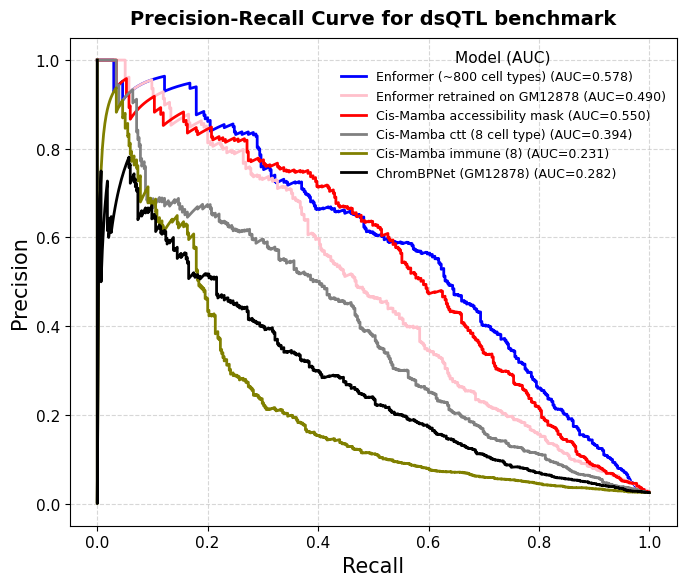

In [3]:
#now let's look at dsqtl results, then we will look at different regions and see if it is predicting larger differences between cell types

# ok this will be slightly annoying...

#we will include the major models, we will not add in alpha genome. 

#let's go ahead and make this one with the dsQTL results


#want to use the same models that we trained with eQTL

from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt


def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    '''
    Predicts variant effect scores based on model predictions.

    Arguments::
       ref_logcount_preds: log count predictions at the reference allele with size (N,)
       alt_logcount_preds: log count predictions at the alternate alele with size (N,)
       ref_prob_preds: profile probability predictions at the reference allele with size (N,outputlen). outputlen depends on the model.
       alt_prob_preds:  profile probability predictions at the alternate allele with size (N,outputlen). outputlen depends on the model.
    
    Returns:
        log_counts_diff: difference in log count predictions of alternate and reference allele (N,)
        log_probs_diff_abs_sum: Sum of absolute difference in log probability prediction of alternate and reference allele per base. (N,)
        probs_jsd_diff: Jensenshannon distance between probability predictions of alternate and reference allele (N,)
    '''
    # log_counts_diff = np.mean(alt_prob_preds, axis=1) - np.mean(ref_prob_preds, axis=1) #model doesn't have count prediction head, so it's really bad!
    # log_counts_diff = alt_count_preds - ref_count_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)
    probs_jsd_diff = np.array([jensenshannon(x,y) for x,y in zip(alt_prob_preds, ref_prob_preds)])
    # integrative_effect_size = log_probs_diff_abs_sum * probs_jsd_diff
    logfc = np.log2(ref_prob_preds.mean(1) / alt_prob_preds.mean(1))
    integrative_effect_size = logfc * probs_jsd_diff
    integrative_effect_size_2 = log_probs_diff_abs_sum * probs_jsd_diff

    return logfc, log_probs_diff_abs_sum, probs_jsd_diff, integrative_effect_size, integrative_effect_size_2



qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/filtered_dsqtls.txt', sep='\t')
def plot_metrics(out, labels, title):
    model_names = ['logfc', 'log_probs_diff_abs_sum', 'JSD', 'IED1', 'IED2']
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    plt.figure(figsize=(6, 5))

    # # === ROC Curve ===
    # plt.subplot(1, 2, 1)
    # for i in range(len(model_names)):
    #     fpr, tpr, _ = roc_curve(labels, out[i])
    #     roc_auc = auc(fpr, tpr)
    #     plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.3f})', color=colors[i])

    # plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    # plt.title('ROC Curve')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.legend()

    # === Precision-Recall Curve ===
    # plt.subplot(1, 2, 2)
    for i in range(len(model_names)):
        precision, recall, _ = precision_recall_curve(labels, np.abs(out[i]))
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_names[i]} (AUC = {pr_auc:.3f})', color=colors[i])

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()
    
def softmax(x, temp=1):
    norm_x = x - np.mean(x, axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

def predict_snp_effect_scores_bpnet(ref_prob_preds, alt_prob_preds, ref_count_preds, alt_count_preds):
    '''
    Predicts variant effect scores based on model predictions.

    Arguments::
       ref_logcount_preds: log count predictions at the reference allele with size (N,)
       alt_logcount_preds: log count predictions at the alternate alele with size (N,)
       ref_prob_preds: profile probability predictions at the reference allele with size (N,outputlen). outputlen depends on the model.
       alt_prob_preds:  profile probability predictions at the alternate allele with size (N,outputlen). outputlen depends on the model.
    
    Returns:
        log_counts_diff: difference in log count predictions of alternate and reference allele (N,)
        log_probs_diff_abs_sum: Sum of absolute difference in log probability prediction of alternate and reference allele per base. (N,)
        probs_jsd_diff: Jensenshannon distance between probability predictions of alternate and reference allele (N,)
    '''
    
    print(ref_prob_preds.shape, alt_prob_preds.shape, ref_count_preds.shape, alt_count_preds.shape)
    # log_counts_diff = np.mean(alt_prob_preds, axis=1) - np.mean(ref_prob_preds, axis=1) #model doesn't have count prediction head, so it's really bad!
    # log_counts_diff = alt_count_preds - ref_count_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)
    #and account for nan
    log_probs_diff_abs_sum[np.isnan(log_probs_diff_abs_sum)] = 0
    # probs_jsd_diff = np.array([jensenshannon(softmax(x),softmax(y)) for x,y in zip(alt_prob_preds, ref_prob_preds)])
    probs_jsd_diff = np.squeeze([jensenshannon(x, y, base=2.0)
                     for x,y in zip(softmax(alt_prob_preds),
                                    softmax(ref_prob_preds))])
    # integrative_effect_size = log_probs_diff_abs_sum * probs_jsd_diff
    logfc = np.log2(ref_count_preds/alt_count_preds)[:,0]
    integrative_effect_size = logfc * probs_jsd_diff
    integrative_effect_size_2 = log_probs_diff_abs_sum * probs_jsd_diff

    return logfc, log_probs_diff_abs_sum, probs_jsd_diff, integrative_effect_size, integrative_effect_size_2
    
labels = qtls['label'].to_numpy()

#A slightly different version where we don't use mamba 8 cell types but isntead use Enformer on 1 cell type

#make it look better
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, enformer_center=False, titles=None, title=None):
    """
    Plots publication-ready Precision-Recall curves for selected SNP effect metrics.
    """
    metric_index_map = {
        'logfc': 0,
        'log_probs_diff_abs_sum': 1,
        'JSD': 2,
        'IED1': 3,
        'IED2': 4
    }
    assert metric_name in metric_index_map, f"Invalid metric: {metric_name}"
    metric_idx = metric_index_map[metric_name]

    # Set up the figure
    plt.figure(figsize=(7, 6))
    plt.rcParams.update({'font.size': 11})

    # Color cycle and line style
    # color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    line_width = 2

    colors = ['blue', 'pink', 'red', 'gray', 'olive', 'black', 'pink', 'gray', 'olive', 'cyan']

    legend_entries = []

    # Plot each model's PR curve
    for i, file in enumerate(files):
        if file.endswith('.npz'):
            pred_cbp = np.load('/data1/lesliec/sarthak/data/joint_playground/chrombpnet/GM12878_Tcellbias/var_prds.npz')
            out = predict_snp_effect_scores_bpnet(
                pred_cbp['profile'][:, :, 0],
                pred_cbp['profile'][:, :, 1],
                pred_cbp['counts'][:, :, 0],
                pred_cbp['counts'][:, :, 1]
            )
        else:
            eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/dsQTL/{file}')
            if enformer_center and 'enformer' in file:
                eqtl_data = eqtl_data[:, 440:456, :]
            out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])

        if i == 0:
            non_zero_mask = (out[0] != 0)

        scores = np.abs(out[metric_idx])[non_zero_mask]
        precision, recall, _ = precision_recall_curve(labels[non_zero_mask], scores)
        pr_auc = auc(recall, precision)

        line, = plt.plot(
            recall,
            precision,
            label=titles[i] if titles else file,
            color=colors[i],
            linewidth=line_width
        )
        legend_entries.append((pr_auc, line, f"{titles[i]} (AUC={pr_auc:.3f})"))

    # Format title and labels
    plt.title(
        title or f'Precision–Recall Curve ({metric_name.upper()})',
        fontsize=14,
        fontweight='bold',
        pad=10
    )
    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)

    # Grid for readability
    plt.grid(axis='both', linestyle='--', alpha=0.5)

    # Sort legend by AUC if requested
    if sort_legend_by_auc:
        legend_entries.sort(key=lambda x: x[0], reverse=True)
    handles = [entry[1] for entry in legend_entries]
    labels_sorted = [entry[2] for entry in legend_entries]

    # Legend styling
    plt.legend(
        handles,
        labels_sorted,
        title='Model (AUC)',
        title_fontsize=11,
        fontsize=9,
        loc='upper right',
        frameon=False
    )

    # Tight layout and display
    plt.tight_layout()
    plt.show()

files = ['enformer_dsqtl.npy', 'enformer_dsqtl_retrained-dsqtl.npy', 'nomlm_maskonly.npy', 'ctt_legacy.npy', 'immune_all_2.npy', '.npz']
titles = ['Enformer (~800 cell types)', 'Enformer retrained on GM12878', 'Cis-Mamba accessibility mask', 'Cis-Mamba ctt (8 cell type)', 'Cis-Mamba immune (8)',
                     'ChromBPNet (GM12878)']
plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, enformer_center=True, titles=titles, title='Precision-Recall Curve for dsQTL benchmark')

# now looking at sample outputs

In [2]:
#let's get the eval class and import the other
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import argparse
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
# print(sys.path)
from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus
from src.tasks.decoders import JointMaskingDecoder
from src.tasks.encoders import JointCNNWithCTT
# from src.tasks.encoders import EnformerEncoder
from caduceus.configuration_caduceus import CaduceusConfig
from src.dataloaders.datasets.general_dataset import GeneralDataset
import yaml
from omegaconf import OmegaConf
import os
# import seaborn as sns
import itertools
import inspect
import zarr
from numcodecs import Blosc
from scipy.stats import spearmanr, pearsonr

try:
    OmegaConf.register_new_resolver('eval', eval)
    OmegaConf.register_new_resolver('div_up', lambda x, y: (x + y - 1) // y)
except ValueError as e:
    if "Resolver already registered" in str(e):
            print("Resolver already exists, skipping registration.")
class Evals():
    def __init__(self,
                 ckpt_path,
                 dataset=None,
                 split = 'test',
                 device = None,
                 load_data=False,
                 **dataset_overrides #Don't pass None into overrides unless you intentionally want it to be None! Pass in items only that you need
                #  data_idxs=None, #the actual value in the full self.dataset.data (so for GM12878 it's 12 or 69). Lets you access a new celltype or just subset to a smaller set of celltypes
                #  sequences_bed_file=None,
                 ) -> None:
        #TODO make it so that we can take in arbitrary dataset information in like a dict and adds options to dataset
        
        #now load the cfg from the checkpoint path
        model_cfg_path = os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), '.hydra', 'config.yaml')
        cfg = yaml.load(open(model_cfg_path, 'r'), Loader=yaml.FullLoader)
        cfg = OmegaConf.create(cfg)
        self.cfg = OmegaConf.to_container(cfg, resolve=True)
        
        if self.cfg['train'].get('custom_metric', None) == 'ce_loss_mask_acc': #makes sure we never do softplus in the loss if it's a categorical model!
            self.skip_softplus=True
        else:
            self.skip_softplus=False
        
        state_dict = torch.load(ckpt_path, map_location='cpu')
        if device is not None:
            #if we are given a device, we will use that device
            self.device = torch.device(device)
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.split = split

        #now set up dataset
        if dataset is None:
            dataset_args = self.cfg['dataset']
            sig = inspect.signature(GeneralDataset.__init__)
            sig = {k: v for k, v in sig.parameters.items() if k != 'self'}
            to_remove = []
            for k, v in dataset_args.items():
                if k not in sig:
                    # del dataset_args[k]
                    to_remove.append(k)
            for k in to_remove:
                del dataset_args[k]
            dataset_args['split'] = split
            dataset_args['evaluating'] = True #this tells it to not do things like random shifting and rc aug, still does random masking tho, can get og sequence easily
            dataset_args['load_in'] = load_data
            
            for k, v in dataset_overrides.items():
                if k in sig:
                    dataset_args[k] = v
                    print(f"Overriding {k} with {v}")
                else:
                    print(f"Warning: {k} not in dataset args, skipping")
            
            # if data_idxs is not None:
            #     dataset_args['data_idxs'] = data_idxs
            # if sequences_bed_file is not None:
            #     dataset_args['sequences_bed_file'] = sequences_bed_file
            # dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset_args = dataset_args
            # self.dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset = GeneralDataset(**dataset_args)
            
            # self.kmer_len = dataset_args['kmer_len']
            # self.dataset = enformer_dataset.EnformerDataset(split, dataset_args['max_length'], rc_aug = dataset_args['rc_aug'],
            #                                                 return_CAGE=dataset_args['return_CAGE'], cell_type=dataset_args.get('cell_type', None),
            #                                                 kmer_len=dataset_args['kmer_len']) #could use dataloader instead, but again kinda complex
        else:
            self.dataset = dataset
         
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )
        model_state_dict = state_dict["state_dict"]
        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)
        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "decoder" in key:
                decoder_state_dict[key[10:]] = model_state_dict.pop(key)
        encoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "encoder" in key:
                encoder_state_dict[key[10:]] = model_state_dict.pop(key)
        
        cfg['model']['config'].pop('_target_')
        # cfg['model']['config']['complement_map'] = self.dataset.tokenizer.complement_map
        caduceus_cfg = CaduceusConfig(**cfg['model']['config'])
        
        self.backbone = DNAEmbeddingModelCaduceus(config=caduceus_cfg)
        self.backbone.load_state_dict(model_state_dict, strict=True)
        
        #remove self.cfg['decoder']['_name_']
        del self.cfg['decoder']['_name_']
        self.cfg['decoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.decoder = JointMaskingDecoder(**self.cfg['decoder']) #could do with instantiating, but that is rather complex
        self.decoder.load_state_dict(decoder_state_dict, strict=True)
        
        del self.cfg['encoder']['_name_']
        self.cfg['encoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.cfg['encoder']['celltypes'] = 7 #hardcoding for now because it becomes 1 when we use the npz file
        self.encoder = JointCNNWithCTT(**self.cfg['encoder'])
        self.encoder.load_state_dict(encoder_state_dict, strict=True)
        
        self.encoder.to(self.device).eval()
        self.backbone.to(self.device).eval()
        self.decoder.to(self.device).eval()
        
    def __call__(self, idx=None, data=None, softplus=True, og=False):
        #now evaluate the model on one example
        if data is None:
            (seq,acc,ctt),(seq_unmask,acc_unmask) = self.dataset[idx]
            
            x = seq.unsqueeze(0)
            y = acc.unsqueeze(0)
            ctt = ctt.unsqueeze(0)
        else:
            x,y,ctt,seq_unmask,acc_unmask = data

            if x.dim() == 2:
                x = x.unsqueeze(0) #add batch dim
                y = y.unsqueeze(0) #add batch dim
                ctt = ctt.unsqueeze(0)
        
        x,y = x.to(self.device), y.to(self.device)
        ctt = ctt.to(self.device)
        
        with torch.no_grad():
            # print(x.shape, y.shape, ctt.shape)
            # print(ctt) #is indeed 6
            x1 = self.encoder(x,y,ctt)
            # print(torch.allclose(x1[0,:,0], self.encoder.ctt_embedding(ctt))) #is indeed true!!
            x1,_ = self.backbone(x1)
            x1 = self.decoder(x1)
            seq,acc = x1

            if softplus and not self.skip_softplus:
                acc = torch.nn.functional.softplus(x1[1])
        
        return seq, acc, seq_unmask, acc_unmask
    
    def freeze(self):
        '''freezes the model, so that it doesn't update the weights during training'''
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.decoder.parameters():
            param.requires_grad = False
    
    def mask(self, start=None, stop=None, idx=None, data=None, run=True,
             mask_accessibility=False, mask_sequence=False,
             randomize_sequence=False, randomize_accessibility=False,
             start_acc=None, stop_acc=None, ctt_val=None
             ):
        '''given an index for the dataset, or just the data, it can mask the data that you want, then runs it through the model, lots of options like to mask accessibility or sequence etc.
        If you don't mask anything, then it's like seeing how confident the model is. But it can mask out regions and see that
        
        Args:
            start (int): the start index to mask, if None requires you don't randomize or mask anything
            stop (int): the end index to mask, if None requires you don't randomize or mask anything
            idx (int, optional): the index of the data in the dataset to use. If None, data must be provided. Defaults to None.
            data (tuple, optional): the data to use, in the form of (x,y,seq_unmask,acc_unmask). If None, idx must be provided. Defaults to None.
            run (bool, optional): whether to run the model on the masked data. If False, it will just return the masked data. Defaults to True.
            mask_accessibility (bool, optional): whether to mask the accessibility values. Defaults to False.
            mask_sequence (bool, optional): whether to mask the sequence values. Defaults to False.
            randomize_sequence (bool, optional): whether to randomize the sequence values instead of masking them. Defaults to False.
            randomize_accessibility (bool, optional): whether to randomize the accessibility values instead of masking them. Defaults to False.
            start_acc (int, optional): the start index to randomize the accessibility values. If None, defaults to start
            stop_acc (int, optional): the end index to randomize the accessibility values. If None, defaults to stop
            
        Returns:
            seq_out (torch.Tensor): the output sequence after running the model, if run is True.
            acc_out (torch.Tensor): the output accessibility after running the model, if run is True.
            seq_unmask_out (torch.Tensor): the original unmasked sequence, if run is True.
            acc_unmask_out (torch.Tensor): the original unmasked accessibility, if run is True.
            x (torch.Tensor): the input sequence after masking, if run is True.
            y (torch.Tensor): the input accessibility after masking, if run is True.
        '''
        if data is not None:
            (x,y,seq_unmask,acc_unmask) = data
        elif idx is not None:
            (x,y),(seq_unmask,acc_unmask) = self.dataset[idx]
        else:
            raise ValueError("Must provide either idx or data")
        
        #now mask the data
        seq = seq_unmask.clone().transpose(1,0) #now is N x length
        acc = acc_unmask.clone().transpose(1,0)
        acc[-1] = 0
        seq[-1] = 0 #zero out the mask so it runs unmasked
        
        if start_acc is None:
            start_acc = start
            stop_acc = stop
        
        if randomize_accessibility:
            random_start = np.random.randint(0, acc.shape[1] - (stop_acc-start_acc)-1) #doesn't include the end point
            acc[0,start:stop] = acc[0,random_start:random_start+(stop_acc-start_acc)]
        
        if mask_accessibility:
            acc[-1, start_acc:stop_acc] = 1 #tells the model it's masked
            acc[0, start_acc:stop_acc] = 0 #zero out the original accessibility values
            
        if randomize_sequence:
            random_indices = torch.randint(0, 4, size=(stop-start,))
            seq[:4,start:stop] = torch.nn.functional.one_hot(random_indices, num_classes=4).transpose(1,0)
            
        if mask_sequence:
            seq[-1,start:stop] = 1
            seq[:-1,start:stop] = 0 #zero out the original sequence values
        
        #now we manually define ctt
        ctt = torch.tensor([ctt_val], dtype=torch.long)
        
        if run:
            x = seq.unsqueeze(0).to(self.device)
            y = acc.unsqueeze(0).to(self.device)
            # ctt = ctt.unsqueeze(0).to(self.device)
            data = (x,y,ctt,seq_unmask,acc_unmask)
            seq_out, acc_out, seq_unmask_out, acc_unmask_out = self(data=data)
        
            return seq_out, acc_out, seq_unmask_out, acc_unmask_out, x, y #it returns the values that were used as inputs, so yyou can see the modified inputs as well as th eoriginal data
        
        else:
            #just return the masked data
            x = seq.unsqueeze(0)
            y = acc.unsqueeze(0)
            return None, None, seq_unmask, acc_unmask, x, y

In [3]:
#and let's import the normal one as well
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from evals.evals_utils_joint import Evals as Evals2


In [4]:
#so now we can create both of them
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-05-15/17-49-16-937449/checkpoints/07-val_loss=0.16646.ckpt'
eval_ctt = Evals(ckpt_path, load_data=False)
print(len(eval_ctt.dataset))

#and now the normal one
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-05-28/22-15-50-972421/checkpoints/15-val_loss=0.16640.ckpt'
evals = Evals2(ckpt_path, load_data=False)
print(len(evals.dataset))

replacing cell type number with data indices, 7
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1, upsample=1
JointMaskingEncoder: d_model=256, celltypes=7, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous
7434
replacing cell type number with data indices, 7
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1, upsample=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous
7434


In [5]:
#let's ensure both the outputs are exactly the same?
a,b = eval_ctt.dataset[0]
a2,b2 = evals.dataset[0]
for i in range(len(a)):
    print(f'a[{i}] shape is {a[i].shape}, a2[{i}] shape is {a2[i].shape}, equal: {torch.allclose(a[i], a2[i])}')

a[0] shape is torch.Size([6, 524288]), a2[0] shape is torch.Size([6, 524288]), equal: True
a[1] shape is torch.Size([2, 524288]), a2[1] shape is torch.Size([2, 524288]), equal: False


IndexError: tuple index out of range

In [6]:
#oh does one use the reprocessed data? or is it the masking?
evals.cfg['dataset']
#hmm no should be using the same dataseat

{'data_path': '/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/dnase_chunkchrom_processed.zarr',
 'length': 524288,
 'shift_sequences': 1000,
 'load_in': False,
 'rc_aug': False,
 'mlm': 0,
 'acc_mlm': 0.25,
 'acc_type': 'continuous',
 'acc_mask_size': 500,
 'weight_peaks': False,
 'data_idxs': '/data1/lesliec/sarthak/data/DK_zarr/idx_lists/all_matched_immune.json',
 'mask_only': True,
 'split': 'test',
 'evaluating': True}

In [7]:
#it must be the masking?
a[1].max(1) #yeah so the masking is done. Use the .mask approach to just get a value I guess?
#but looks like the data itself should be fine

torch.return_types.max(
values=tensor([13.0938,  1.0000]),
indices=tensor([499185,   4500]))

In [8]:
#check if b is the same
for i in range(len(b)):
    print(f'b[{i}] shape is {b[i].shape}, b2[{i}] shape is {b2[i].shape}, equal: {torch.allclose(b[i], b2[i])}')
#wait if masks are different that will of course differ lol

b[0] shape is torch.Size([524288, 6]), b2[0] shape is torch.Size([524288, 6]), equal: True
b[1] shape is torch.Size([524288, 2]), b2[1] shape is torch.Size([524288, 2]), equal: False


In [9]:
b[1].shape

torch.Size([524288, 2])

In [10]:
#ok this is nothing, let's choose a different sample
a,b = eval_ctt.dataset[10]
# plt.plot(a[1][:,0])

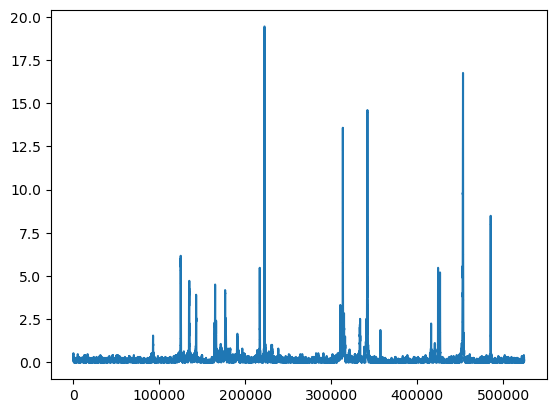

In [11]:
#let's plot the actual data
import matplotlib.pyplot as plt
plt.plot(b[1][:,0]) #b is the unmasked, 1 is accessibility, and we see some decent stuff

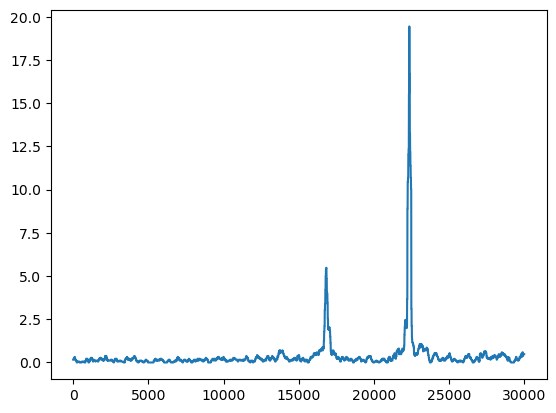

In [12]:
#let's zoom in
plt.plot(b[1][200_000:230_000,0])

In [13]:
#ok so let's do this, we'll get max index, then we'll plot from that
max_index = torch.argmax(b[1][:,0])
max_index #now we'll plot from 220_000 to 230_000 and mask 500 in each direction

tensor(222345)

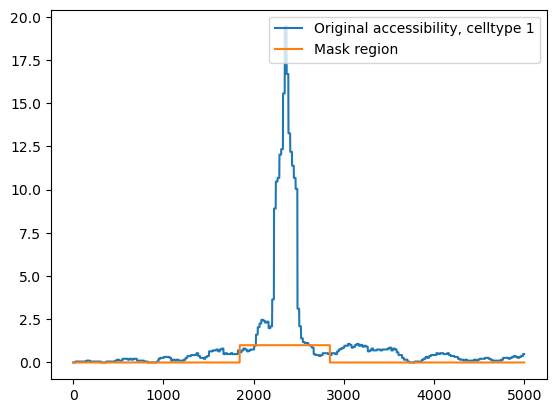

In [14]:
plt.plot(b[1][220_000:225_000,0], label='Original accessibility, celltype 1')
#and plot the mask
mask = torch.zeros(b[1].shape)
mask[max_index-500:max_index+500,0] = 1
plt.plot(mask[220_000:225_000,0], label='Mask region')
plt.legend()

In [15]:
evals.dataset.sequences

,0,1,2,3
0,chr4,0,524288,test
1,chr4,262144,786432,test
2,chr4,524288,1048576,test
3,chr4,786432,1310720,test
4,chr4,1048576,1572864,test
...,...,...,...,...
1057,chr14,105381888,105906176,test
1058,chr14,105644032,106168320,test
1059,chr14,105906176,106430464,test
1060,chr14,106168320,106692608,test


In [16]:
#a few final edits, but I like this one. first maks will be 1000 each direction
#oh and we should assert seq is always the same
#idxs should be 10, 10+1062, 10+2*1062 up to a max of len(evals.dataset)
idxs = [10 + i*1062 for i in range(7)]
idxs

[10, 1072, 2134, 3196, 4258, 5320, 6382]

In [31]:
#looks right to me, now we should test it tho
from tqdm import tqdm
for idx in tqdm(idxs):
    (seq1, acc1, ctt), (seq_unmask1, acc_unmask1) = eval_ctt.dataset[idx]
    (seq2, acc2), (seq_unmask2, acc_unmask2) = evals.dataset[idx]
    assert torch.allclose(seq1, seq2), f"Sequence outputs not equal for idx {idx}"
    #and assert that the unmasked acc is equal
    assert torch.allclose(acc_unmask1[:,0], acc_unmask2[:,0]), f"Unmasked accessibility outputs not equal for idx {idx}"
    #and assert it's close to the original sequence
    assert torch.allclose(seq1, a[0]), f"Sequence not equal to original for idx {idx}"

100%|██████████| 7/7 [00:43<00:00,  6.20s/it]


In [17]:
#ok perfect sequence and accessibilities match!!
si = max_index-1000
se = max_index+1000
#these are set, just used for the mask function

In [18]:
#now we can loop through and do the masking, let's test the masking first
x,(su,au) = eval_ctt.dataset[10]
data = (None,None,su,au)
out1 = eval_ctt.mask(si,se,data=data,mask_accessibility=True,ctt_val=0)


In [19]:
out1[1].shape

torch.Size([1, 524288, 1])

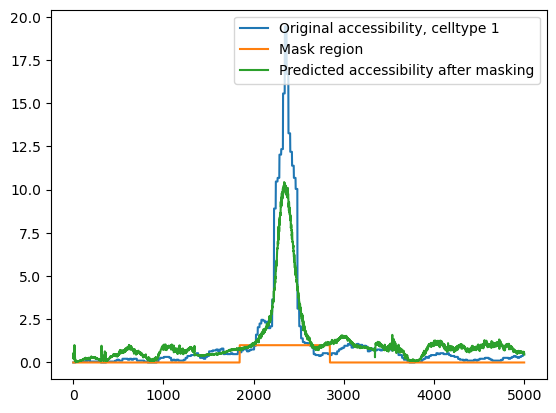

In [20]:
#the prediction would be out1[1]
plt.plot(au[220_000:225_000,0], label='Original accessibility, celltype 1')
#and plot the mask
mask = torch.zeros(b[1].shape)
mask[max_index-500:max_index+500,0] = 1
plt.plot(mask[220_000:225_000,0], label='Mask region')

plt.plot(out1[1][0,220_000:225_000,0].cpu().numpy(), label='Predicted accessibility after masking')

plt.legend()

In [21]:
x[2]

tensor(0)

In [24]:
#let's get the cell type labels too
import pandas as pd
enf_targets = pd.read_csv('/data1/lesliec/sarthak/data/DK_zarr/targets_enformer.txt', sep='\t')
#now we need to get these rows evals.dataset.data_idxs

ctt_labels = []
for idx in evals.dataset.data_idxs:
    print(idx)
    ctt_labels.append(enf_targets.iloc[idx,7].split(':')[1])
ctt_labels

457
177
354
120
522
392
12


['CD4-positive, alpha-beta T cell male adult (21 year)',
 'CD8-positive, alpha-beta T cell male adult (21 year)',
 'B cell male adult (21 year)',
 'Jurkat clone E61',
 'natural killer cell male adult (21 year)',
 'CD14-positive monocyte male adult (21 year)',
 'GM12878']

Text(0.5, 0.98, 'Cell type token model')

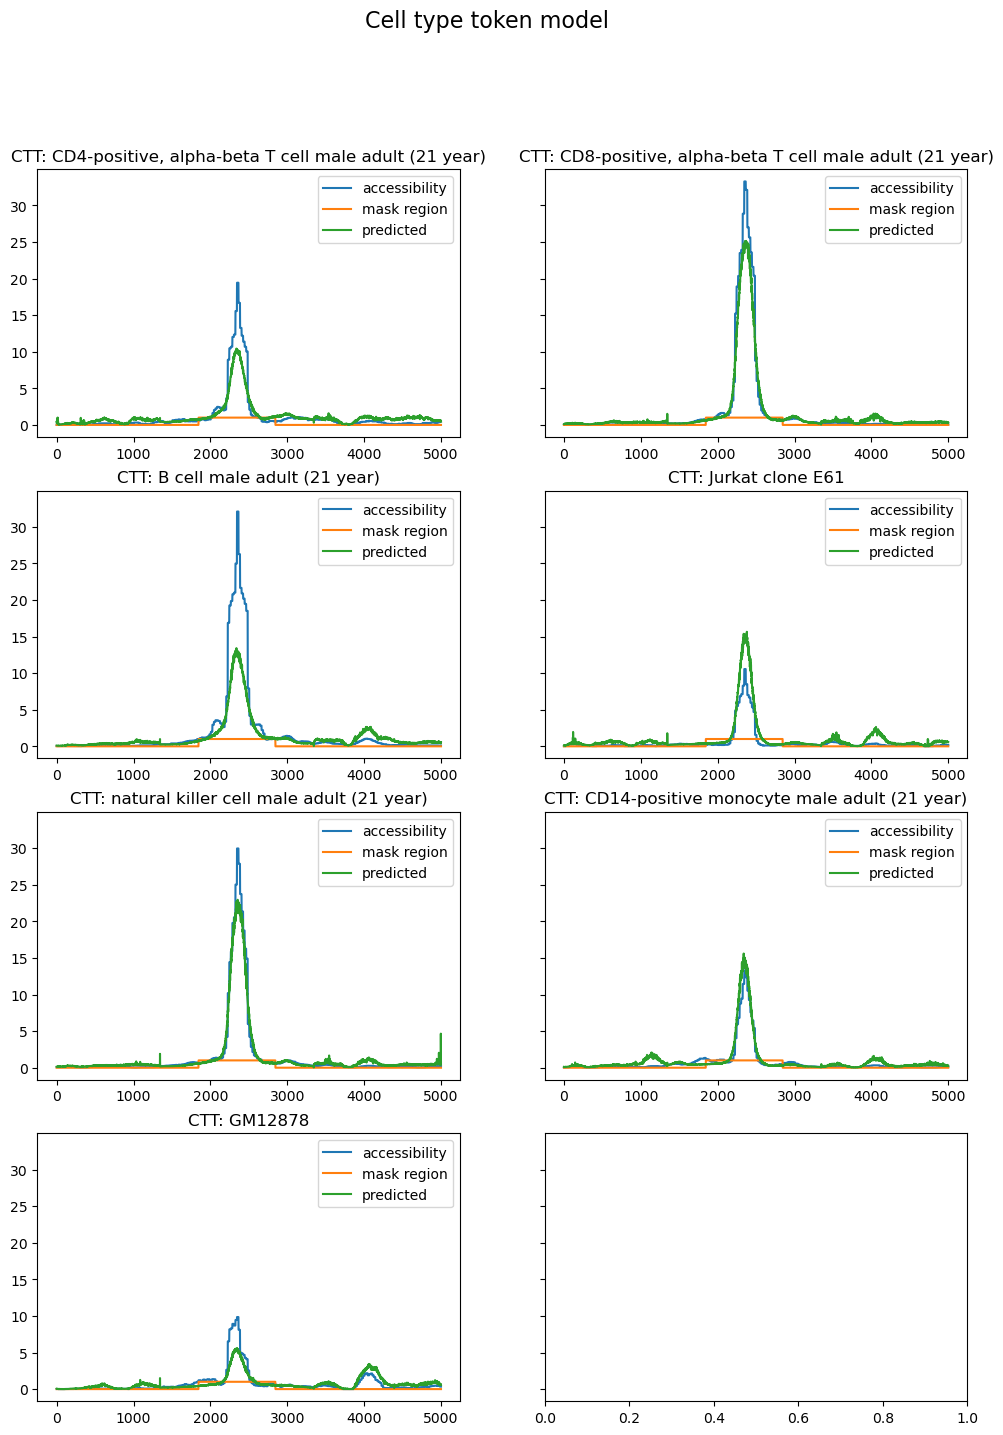

In [26]:
#now we can make this a subplot with just the ctt model. There are a total of 7, so make it 4x2
fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i, idx in enumerate(idxs):
    x,(su,au) = eval_ctt.dataset[idx]
    data = (None,None,su,au)
    assert x[2] == i, f"CTT value mismatch for idx {idx}, expected {i}, got {x[2]}"
    out1 = eval_ctt.mask(si,se,data=data,mask_accessibility=True,ctt_val=i)
    axs[i].plot(au[220_000:225_000,0], label='accessibility')
    axs[i].plot(mask[220_000:225_000,0], label='mask region')
    axs[i].plot(out1[1][0,220_000:225_000,0].cpu().numpy(), label='predicted')
    axs[i].set_title(f'CTT: {ctt_labels[i]}')
    axs[i].legend()
#and add a supertitle
fig.suptitle('Cell type token model', fontsize=16)

Text(0.5, 0.98, 'base model')

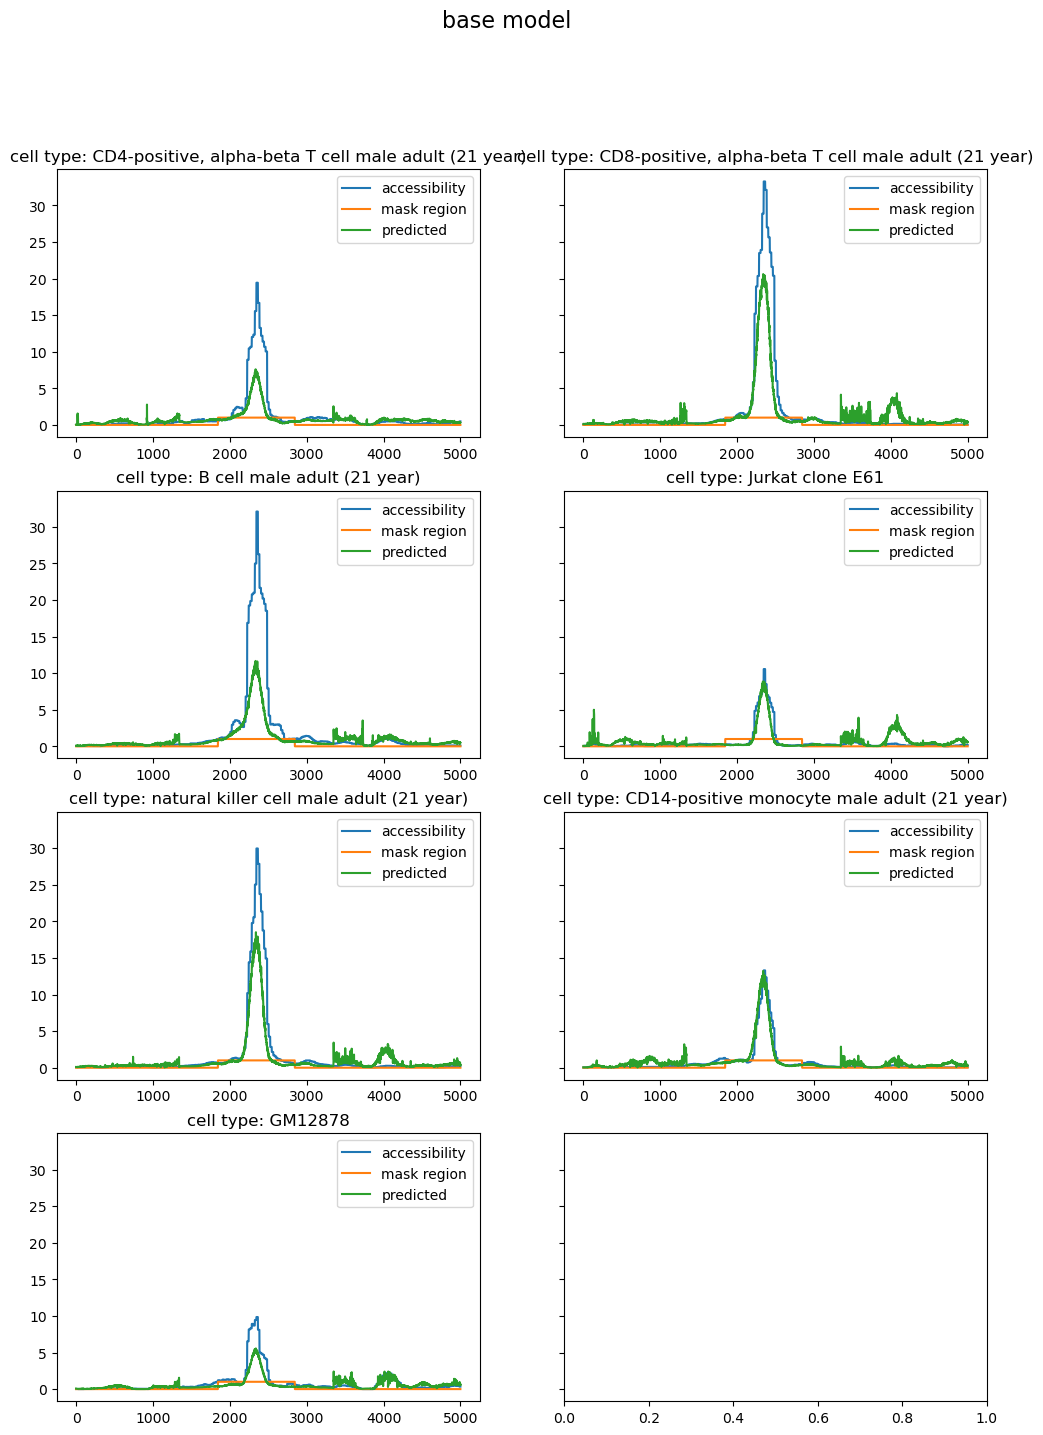

In [28]:
#and let's repeat for the normal model
fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i, idx in enumerate(idxs):
    x,(su,au) = evals.dataset[idx]
    data = (None,None,su,au)
    # assert x[2] == i, f"CTT value mismatch for idx {idx}, expected {i}, got {x[2]}"
    out1 = evals.mask(si,se,data=data,mask_accessibility=True)
    axs[i].plot(au[220_000:225_000,0], label='accessibility')
    axs[i].plot(mask[220_000:225_000,0], label='mask region')
    axs[i].plot(out1[1][0,220_000:225_000,0].cpu().numpy(), label='predicted')
    axs[i].set_title(f'cell type: {ctt_labels[i]}')
    axs[i].legend()
#and add a supertitle
fig.suptitle('base model', fontsize=16)

Text(0.5, 0.98, 'base model')

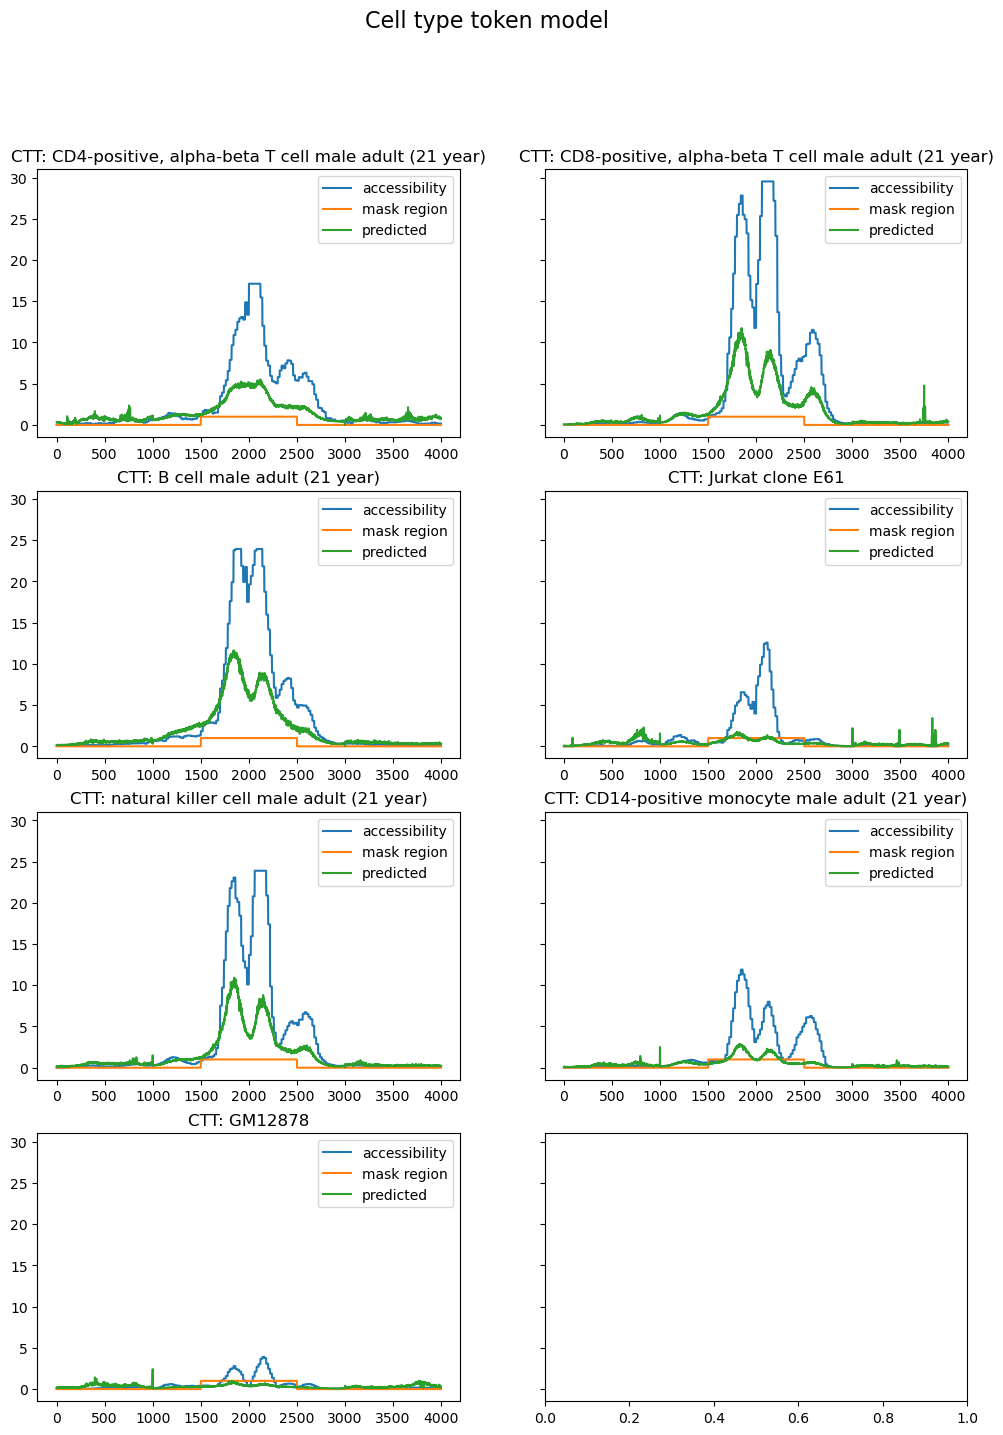

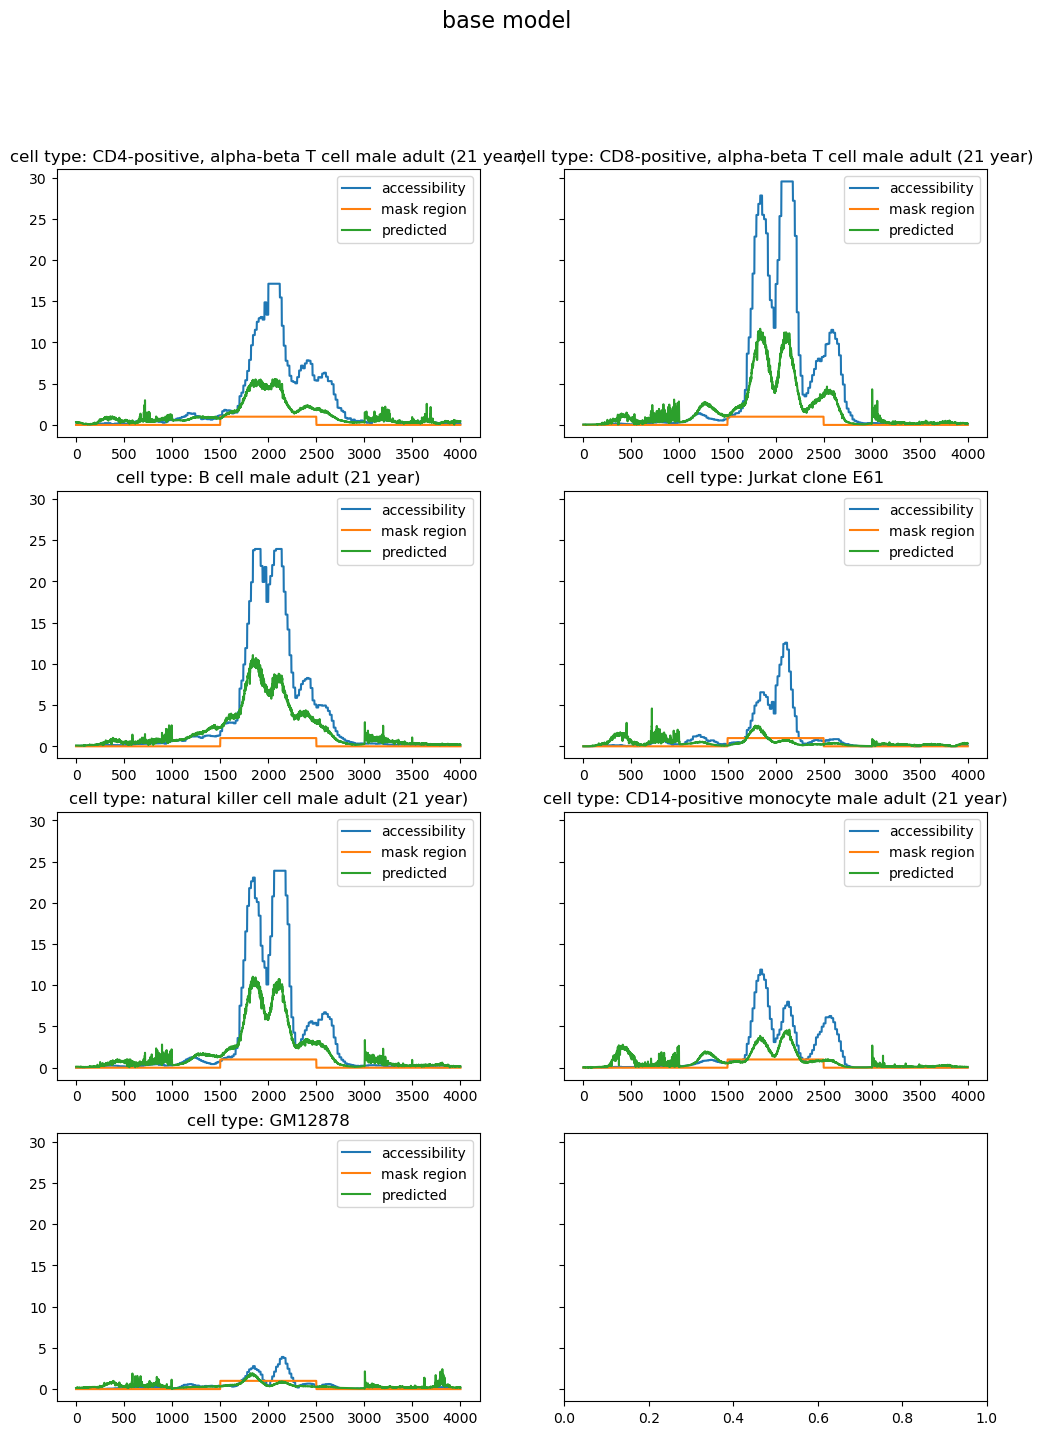

In [ ]:
#let's do this for a different index now, say 50
idxs = [50 + i*1062 for i in range(7)]
#now we need to get a new max index
a,b = eval_ctt.dataset[idxs[0]]
max_index = torch.argmax(b[1][:,0])
si = max_index-1000
se = max_index+1000
mask = torch.zeros(b[1].shape)
mask[max_index-500:max_index+500,0] = 1
#also change how it's plotted
start_plot = max_index - 2000
end_plot = max_index + 2000


fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i, idx in enumerate(idxs):
    x,(su,au) = eval_ctt.dataset[idx]
    data = (None,None,su,au)
    assert x[2] == i, f"CTT value mismatch for idx {idx}, expected {i}, got {x[2]}"
    out1 = eval_ctt.mask(si,se,data=data,mask_accessibility=True,ctt_val=i)
    #change this so now not 220:225 but relative to max index
    axs[i].plot(au[start_plot:end_plot,0], label='accessibility')
    axs[i].plot(mask[start_plot:end_plot,0], label='mask region')
    axs[i].plot(out1[1][0,start_plot:end_plot,0].cpu().numpy(), label='predicted')
    axs[i].set_title(f'CTT: {ctt_labels[i]}')
    axs[i].legend()
#and add a supertitle
fig.suptitle('Cell type token model', fontsize=16)

#and repeat for the normal model
fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i, idx in enumerate(idxs):
    x,(su,au) = evals.dataset[idx]
    data = (None,None,su,au)
    # assert x[2] == i, f"CTT value mismatch for idx {idx}, expected {i}, got {x[2]}"
    out1 = evals.mask(si,se,data=data,mask_accessibility=True)
    axs[i].plot(au[start_plot:end_plot,0], label='accessibility')
    axs[i].plot(mask[start_plot:end_plot,0], label='mask region')
    axs[i].plot(out1[1][0,start_plot:end_plot,0].cpu().numpy(), label='predicted')
    axs[i].set_title(f'cell type: {ctt_labels[i]}')
    axs[i].legend()
#and add a supertitle
fig.suptitle('base model', fontsize=16)

Text(0.5, 0.98, 'base model')

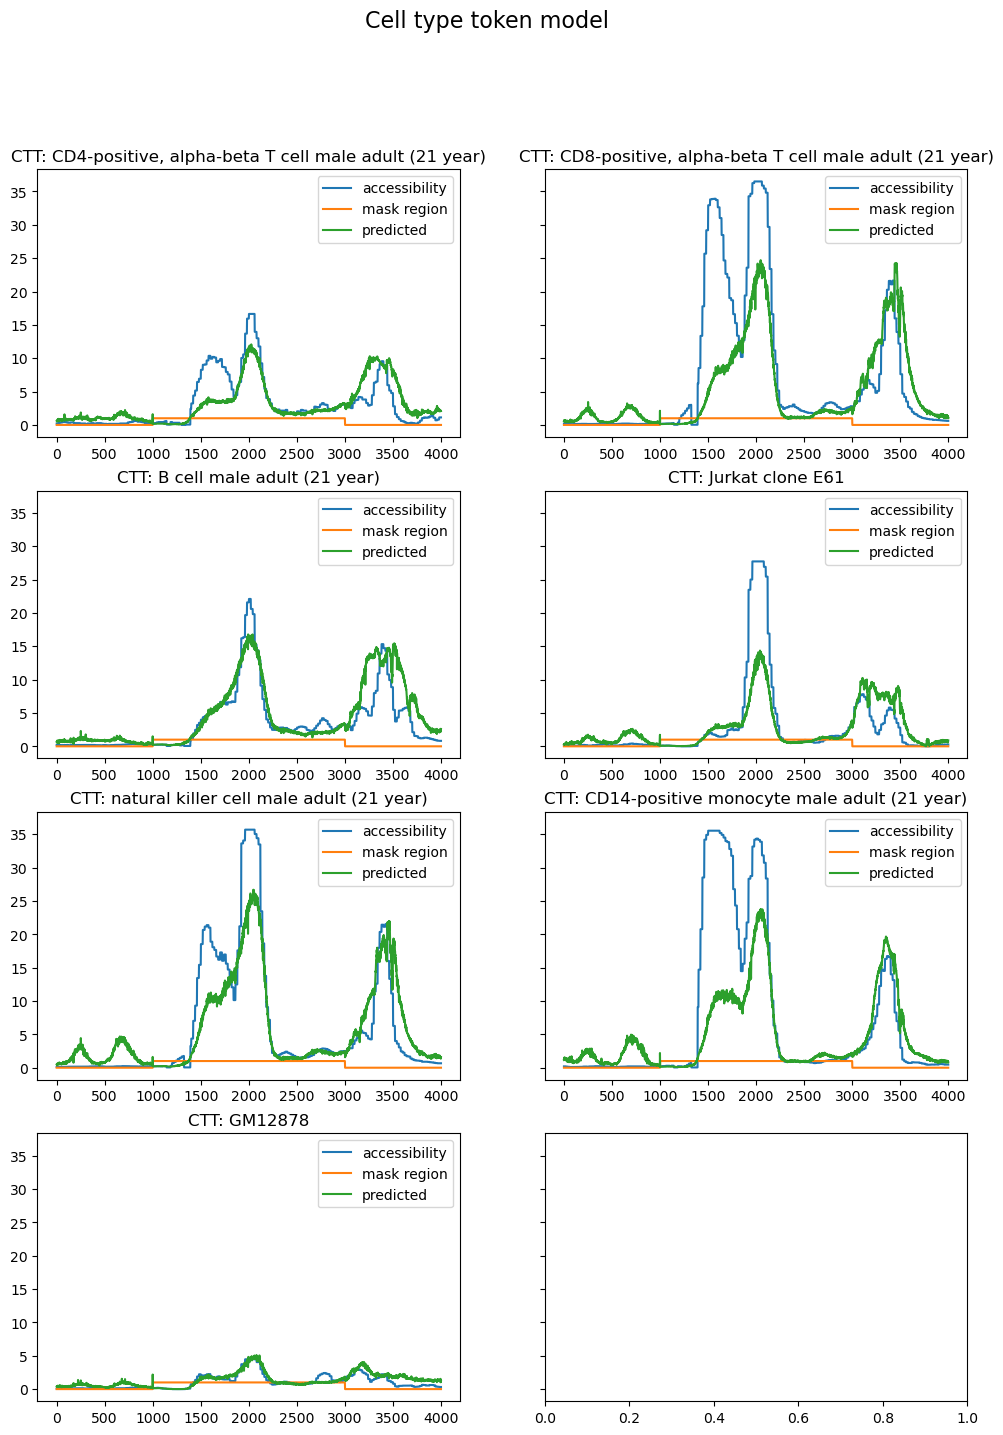

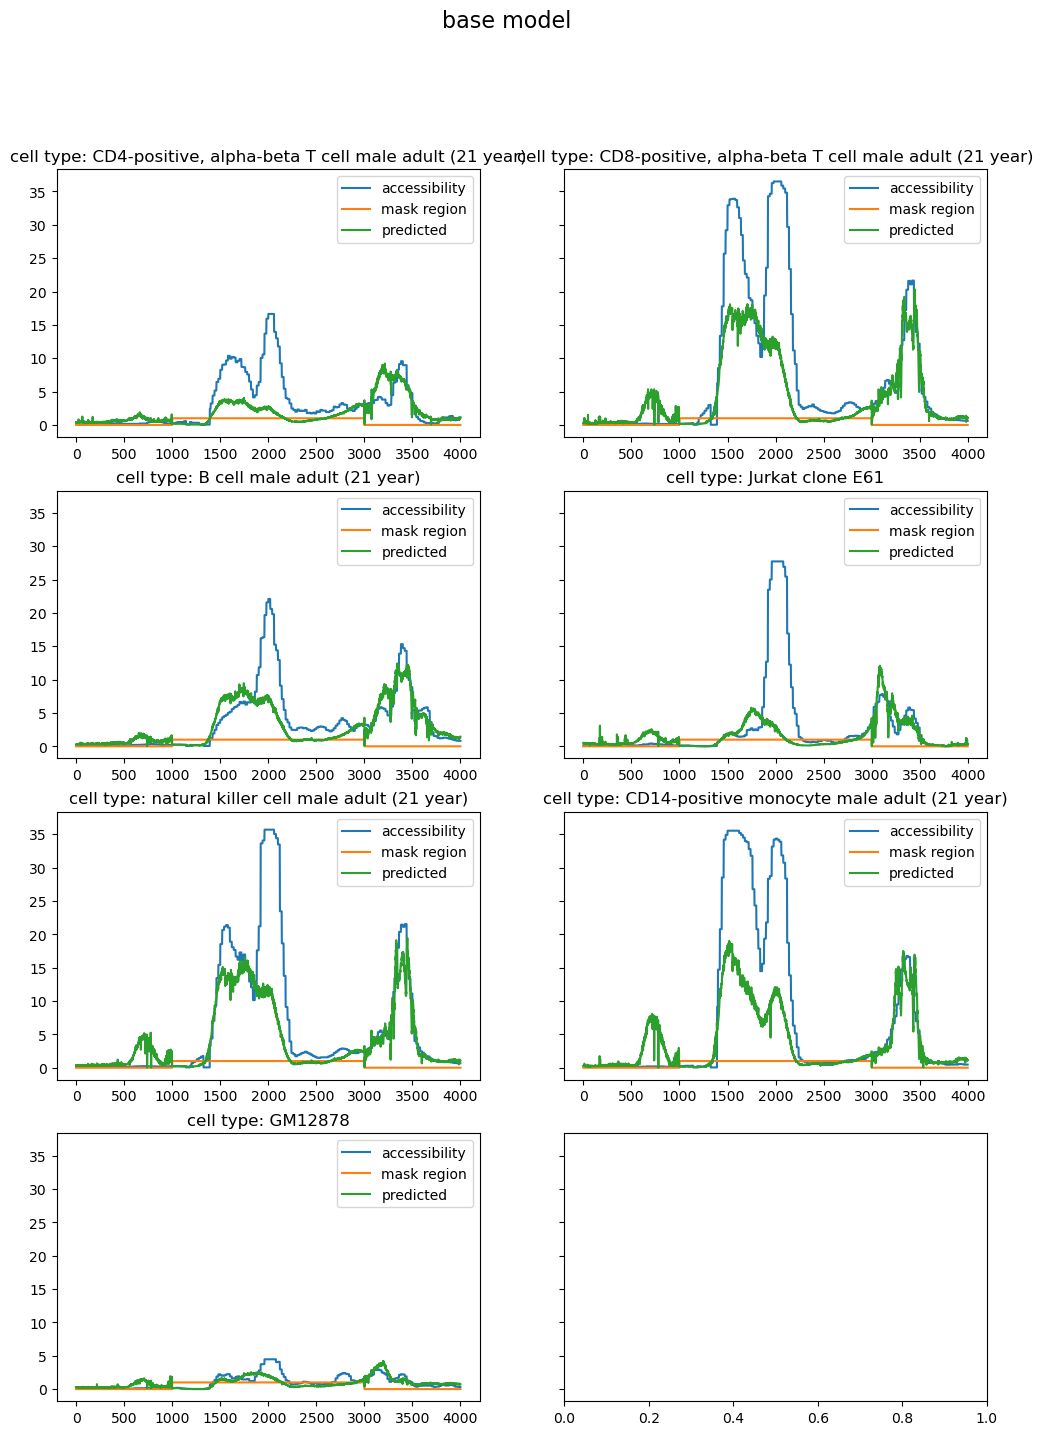

In [36]:
#now try 
# len(evals.dataset.sequences)
#let's try 100 now

#let's do this for a different index now, say 100
idxs = [100 + i*1062 for i in range(7)]
#now we need to get a new max index
a,b = eval_ctt.dataset[idxs[0]]
max_value = b[1][:,0].max()
max_index = torch.argmax(b[1][:,0])
si = max_index-1000
se = max_index+1000
mask = torch.zeros(b[1].shape)
mask[max_index-1000:max_index+1000,0] = 1
#also change how it's plotted
start_plot = max_index - 2000
end_plot = max_index + 2000


fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i, idx in enumerate(idxs):
    x,(su,au) = eval_ctt.dataset[idx]
    data = (None,None,su,au)
    assert x[2] == i, f"CTT value mismatch for idx {idx}, expected {i}, got {x[2]}"
    out1 = eval_ctt.mask(si,se,data=data,mask_accessibility=True,ctt_val=i)
    #change this so now not 220:225 but relative to max index
    axs[i].plot(au[start_plot:end_plot,0], label='accessibility')
    axs[i].plot(mask[start_plot:end_plot,0], label='mask region')
    axs[i].plot(out1[1][0,start_plot:end_plot,0].cpu().numpy(), label='predicted')
    axs[i].set_title(f'CTT: {ctt_labels[i]}')
    axs[i].legend()
#and add a supertitle
fig.suptitle('Cell type token model', fontsize=16)

#and repeat for the normal model
fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i, idx in enumerate(idxs):
    x,(su,au) = evals.dataset[idx]
    data = (None,None,su,au)
    # assert x[2] == i, f"CTT value mismatch for idx {idx}, expected {i}, got {x[2]}"
    out1 = evals.mask(si,se,data=data,mask_accessibility=True)
    axs[i].plot(au[start_plot:end_plot,0], label='accessibility')
    axs[i].plot(mask[start_plot:end_plot,0], label='mask region')
    axs[i].plot(out1[1][0,start_plot:end_plot,0].cpu().numpy(), label='predicted')
    axs[i].set_title(f'cell type: {ctt_labels[i]}')
    axs[i].legend()
#and add a supertitle
fig.suptitle('base model', fontsize=16)

Text(0.5, 0.98, 'base model')

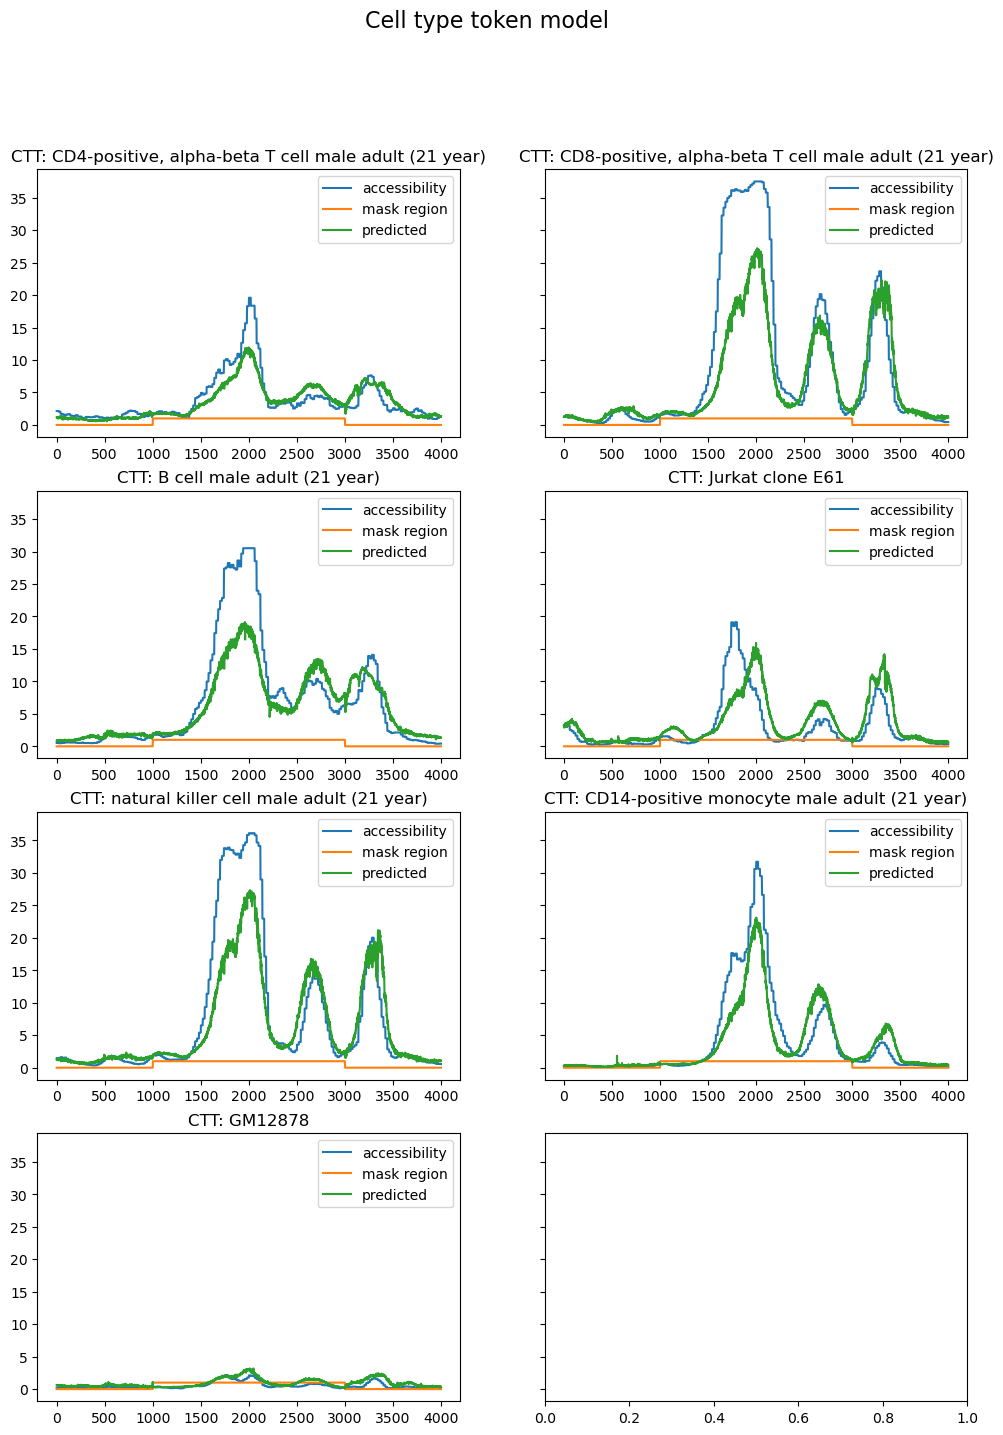

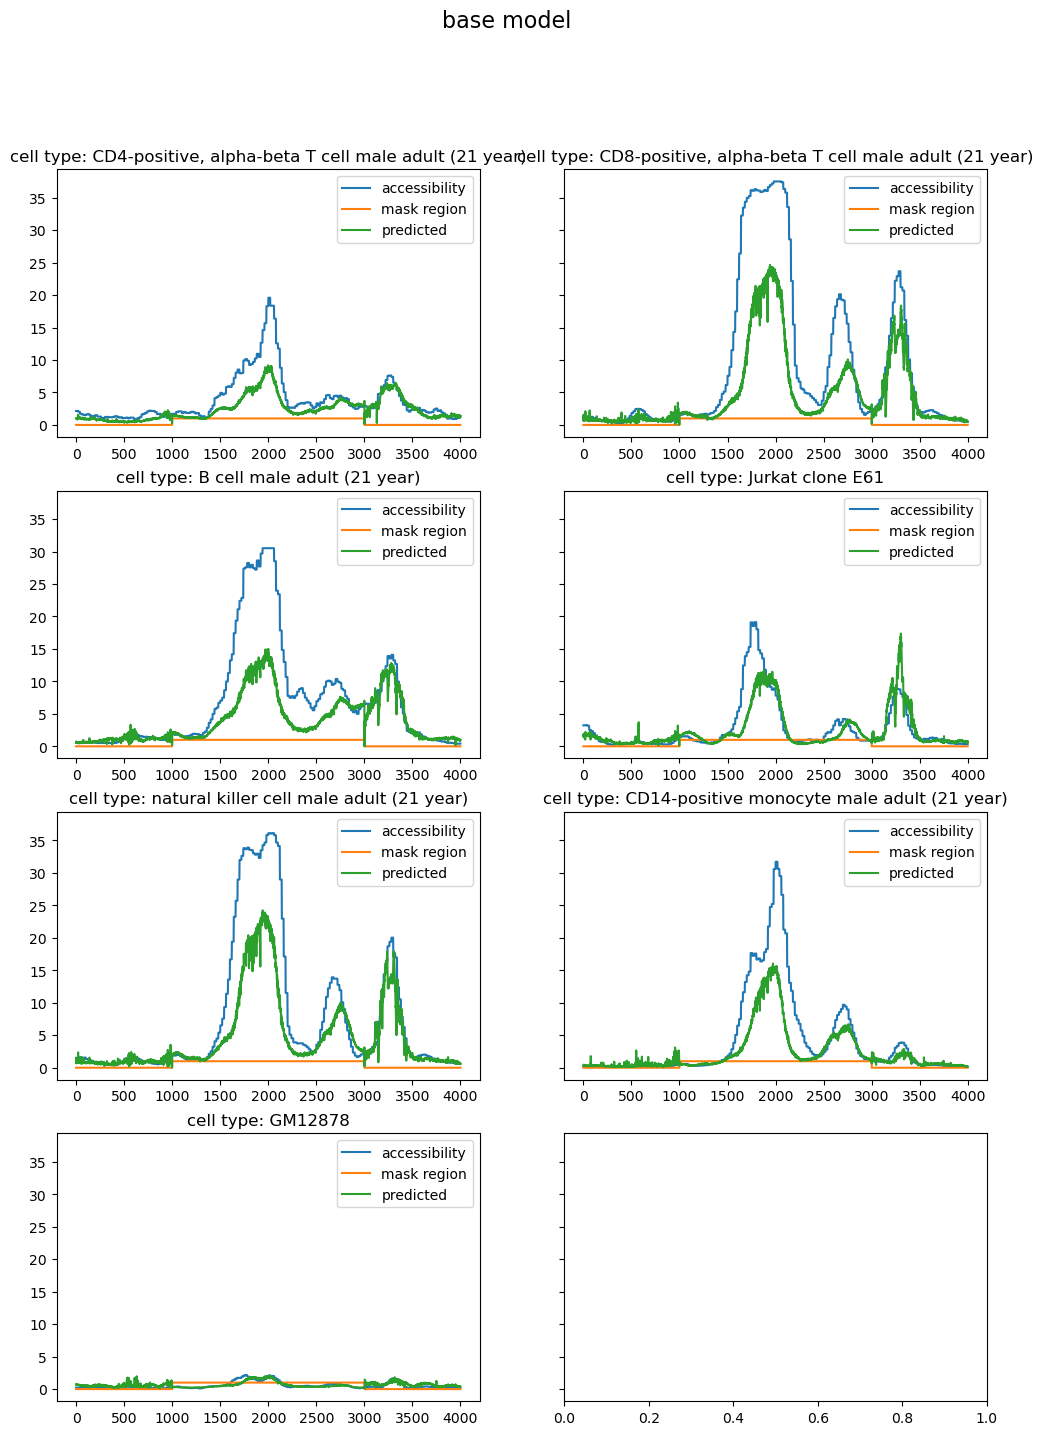

In [45]:
#and just a few more examples

#let's do this for a different index now, say 100
idxs = [900 + i*1062 for i in range(7)]
#now we need to get a new max index
a,b = eval_ctt.dataset[idxs[0]]
max_value = b[1][:,0].max()
if max_value < 3:
    assert False, "Max value too low, choose a different index"
max_index = torch.argmax(b[1][:,0])
si = max_index-1000
se = max_index+1000
mask = torch.zeros(b[1].shape)
mask[max_index-1000:max_index+1000,0] = 1
#also change how it's plotted
start_plot = max_index - 2000
end_plot = max_index + 2000


fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i, idx in enumerate(idxs):
    x,(su,au) = eval_ctt.dataset[idx]
    data = (None,None,su,au)
    assert x[2] == i, f"CTT value mismatch for idx {idx}, expected {i}, got {x[2]}"
    out1 = eval_ctt.mask(si,se,data=data,mask_accessibility=True,ctt_val=i)
    #change this so now not 220:225 but relative to max index
    axs[i].plot(au[start_plot:end_plot,0], label='accessibility')
    axs[i].plot(mask[start_plot:end_plot,0], label='mask region')
    axs[i].plot(out1[1][0,start_plot:end_plot,0].cpu().numpy(), label='predicted')
    axs[i].set_title(f'CTT: {ctt_labels[i]}')
    axs[i].legend()
#and add a supertitle
fig.suptitle('Cell type token model', fontsize=16)

#and repeat for the normal model
fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i, idx in enumerate(idxs):
    x,(su,au) = evals.dataset[idx]
    data = (None,None,su,au)
    # assert x[2] == i, f"CTT value mismatch for idx {idx}, expected {i}, got {x[2]}"
    out1 = evals.mask(si,se,data=data,mask_accessibility=True)
    axs[i].plot(au[start_plot:end_plot,0], label='accessibility')
    axs[i].plot(mask[start_plot:end_plot,0], label='mask region')
    axs[i].plot(out1[1][0,start_plot:end_plot,0].cpu().numpy(), label='predicted')
    axs[i].set_title(f'cell type: {ctt_labels[i]}')
    axs[i].legend()
#and add a supertitle
fig.suptitle('base model', fontsize=16)

Chose index 529 with max value 11.6484375


Text(0.5, 0.98, 'base model')

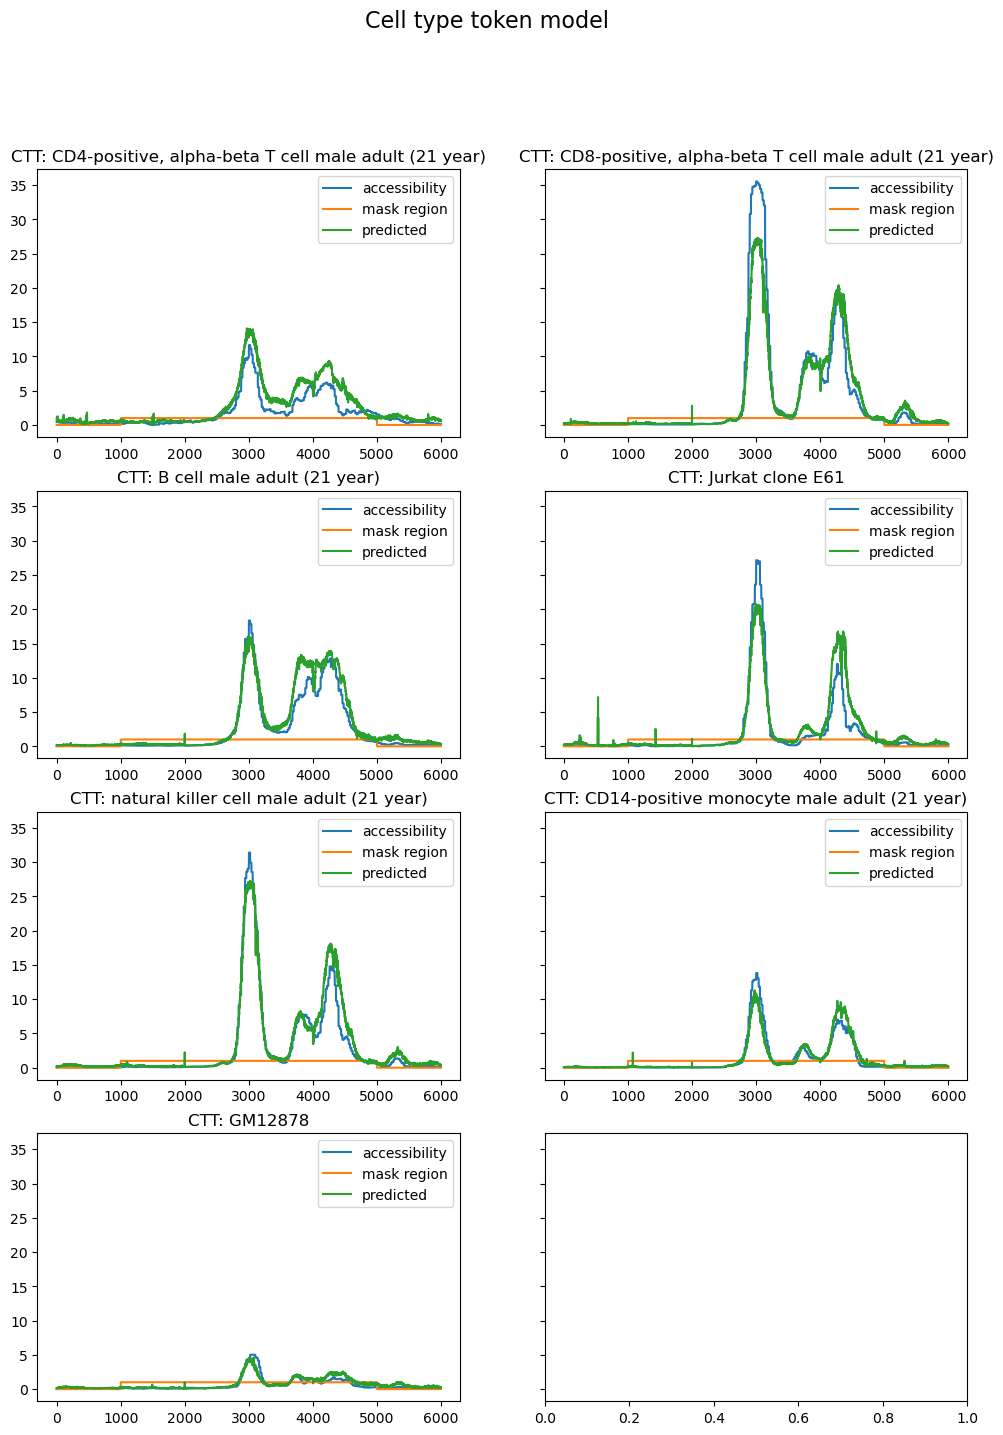

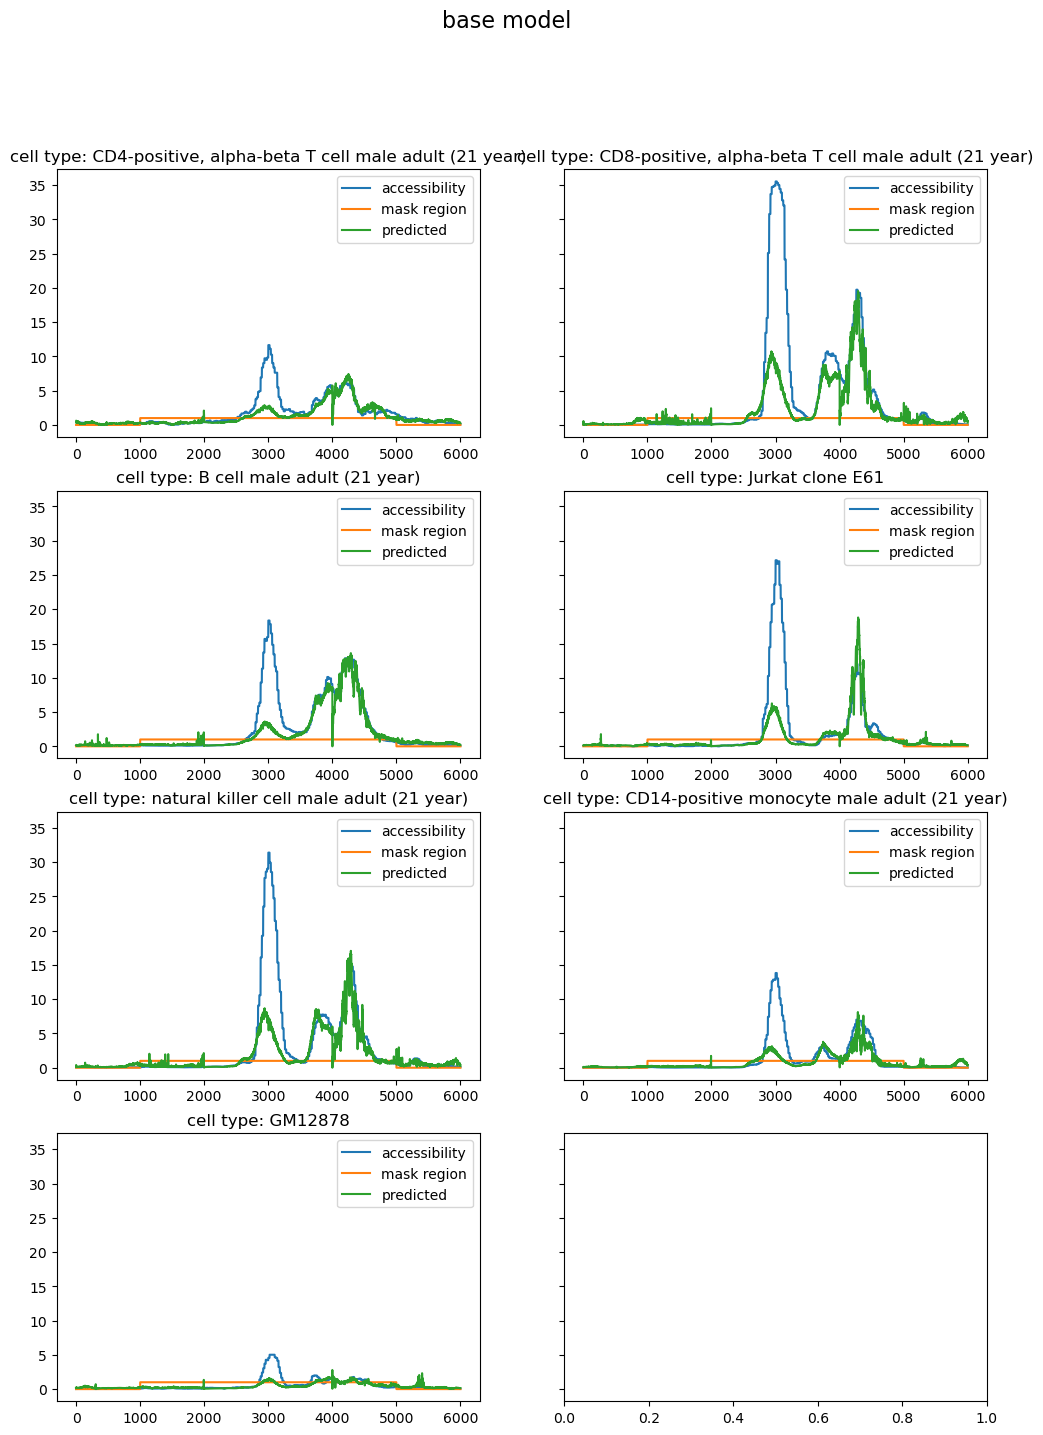

In [54]:
#and just a few more examples
#this time make the mask bigger
for start in range(520,550):
    a,b = eval_ctt.dataset[start]
    max_value = b[1][:,0].max()
    if max_value >= 3:
        print(f"Chose index {start} with max value {max_value}")
        break
idxs = [start + i*1062 for i in range(7)]
#now we need to get a new max index
a,b = eval_ctt.dataset[idxs[0]]
max_value = b[1][:,0].max()
if max_value < 3:
    assert False, "Max value too low, choose a different index"
max_index = torch.argmax(b[1][:,0])
si = max_index-1000
se = max_index+1000
mask = torch.zeros(b[1].shape)
mask[max_index-2000:max_index+2000,0] = 1
#also change how it's plotted
start_plot = max_index - 3000
end_plot = max_index + 3000


fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i, idx in enumerate(idxs):
    x,(su,au) = eval_ctt.dataset[idx]
    data = (None,None,su,au)
    assert x[2] == i, f"CTT value mismatch for idx {idx}, expected {i}, got {x[2]}"
    out1 = eval_ctt.mask(si,se,data=data,mask_accessibility=True,ctt_val=i)
    #change this so now not 220:225 but relative to max index
    axs[i].plot(au[start_plot:end_plot,0], label='accessibility')
    axs[i].plot(mask[start_plot:end_plot,0], label='mask region')
    axs[i].plot(out1[1][0,start_plot:end_plot,0].cpu().numpy(), label='predicted')
    axs[i].set_title(f'CTT: {ctt_labels[i]}')
    axs[i].legend()
#and add a supertitle
fig.suptitle('Cell type token model', fontsize=16)

#and repeat for the normal model
fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i, idx in enumerate(idxs):
    x,(su,au) = evals.dataset[idx]
    data = (None,None,su,au)
    # assert x[2] == i, f"CTT value mismatch for idx {idx}, expected {i}, got {x[2]}"
    out1 = evals.mask(si,se,data=data,mask_accessibility=True)
    axs[i].plot(au[start_plot:end_plot,0], label='accessibility')
    axs[i].plot(mask[start_plot:end_plot,0], label='mask region')
    axs[i].plot(out1[1][0,start_plot:end_plot,0].cpu().numpy(), label='predicted')
    axs[i].set_title(f'cell type: {ctt_labels[i]}')
    axs[i].legend()
#and add a supertitle
fig.suptitle('base model', fontsize=16)